In [1]:
import sys
import json
import time
from collections import defaultdict
import pandas as pd
import os
import numpy as np

sys.path.insert(0, 'src/data')
sys.path.insert(0, 'src/dgl_graphsage')
from src.api.spotifyAPI import SpotifyAPI
from utils import load_data
from train_updated import train

import dgl
import torch
import torch.nn.functional as F
from dgl import save_graphs
from dgl import load_graphs

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

sys.path.insert(0, './src/features')
from build_features import load_data as graph_from_scratch
import re
from torch.nn.functional import normalize

Using backend: pytorch


In [96]:
import recommend as r

# Load Data

In [2]:
# %%time
# # Loading in the data. ~ 00:01:30
# with open('config/data-params.json') as fh:
#     data_cfg = json.load(fh)
# feat_data, adj_list, dgl_G, uri_map = load_data(**data_cfg)

### From Scratch

In [4]:
# uses original files to make the graph from scratch

# def scratch(feat_dir, normal=True):
#     print('Loading feature data...')
#     data = np.genfromtxt(feat_dir, delimiter=',', skip_header=True, dtype=str)
#     features = np.array(np.delete(data[:,2:], -3, 1), dtype=float)
#     if normal:
#         features = normalize(torch.Tensor(features), dim=0)
#     uris = data[:, 1]
#     uris = [re.sub('spotify:track:', '', uri) for uri in uris]
#     uri_map = {n: i for i,n in enumerate(uris)}
    
#     G = graph_from_scratch('./data/a13group1/data/', 'Spotify Playlist', 0, 0, 0)
#     print('graph created')
#     src, dest = [], [] 
#     adj_list = defaultdict(set)    
#     for e in G.edges:
#         u,v = uri_map[e[0]], uri_map[e[1]]
#         adj_list[u].add(v)
#         adj_list[v].add(u)
#         src.append(u)
#         dest.append(v)
        
#     src = torch.tensor(src)
#     dest = torch.tensor(dest)
        
    
#     print('adj list created')
    
#     dgl_G = dgl.graph((src, dest), num_nodes=len(G.nodes))
#     return features, adj_list, dgl_G, uri_map

In [5]:
# '''
# Creates graph from scratch using from_networkx
# results in double edges
# '''
# def scratch(feat_dir, normal=True):
#     print('Loading feature data...')
#     data = np.genfromtxt(feat_dir, delimiter=',', skip_header=True, dtype=str)
#     features = np.array(np.delete(data[:,2:], -3, 1), dtype=float)
#     if normal:
#         features = normalize(torch.Tensor(features), dim=0)
#     uris = data[:, 1]
#     uris = [re.sub('spotify:track:', '', uri) for uri in uris]
#     uri_map = {n: i for i,n in enumerate(uris)}
    
#     G = graph_from_scratch('./data/a13group1/data/', 'Spotify Playlist', 0, 0, 0)
#     print('graph created')
#     src, dest = [], [] 
#     adj_list = defaultdict(set)    
#     for e in G.edges:
#         u,v = uri_map[e[0]], uri_map[e[1]]
#         adj_list[u].add(v)
#         adj_list[v].add(u)
#         src.append(u)
#         dest.append(v)
#     print('adj list created')
    
#     #dgl_G = dgl.graph((src, dest), num_nodes=len(G.nodes))
#     dgl_G = dgl.from_networkx(G)
#     return features, adj_list, dgl_G, uri_map

### Currently the one I am using

In [6]:
# '''
# Loads the double edged graph
# feat_dir = feature directory
# '''
# def load_double_edge(feat_dir, normal=True):
#     print('Loading feature data...')
#     data = np.genfromtxt(feat_dir, delimiter=',', skip_header=True, dtype=str)
#     features = np.array(np.delete(data[:,2:], -3, 1), dtype=float)
#     if normal:
#         features = normalize(torch.Tensor(features), dim=0)
#     uris = data[:, 1]
#     uris = [re.sub('spotify:track:', '', uri) for uri in uris]
#     uri_map = {n: i for i,n in enumerate(uris)}
#     listed = list(uri_map)
    
#     G  = load_graphs("./data/a13group1/double_edges_170k.bin")[0][0]
#     print('Loaded DGL Graph')
#     sources = G.edges()[0] 
#     destinations = G.edges()[1]
    
#     src, dest = [], [] 
#     adj_list = defaultdict(set)
#     for e in range(len((G.edges()[0]))):
#         u,v = sources[e].item(), destinations[e].item()
#         adj_list[u].add(v)
#         adj_list[v].add(u)
#         src.append(u)
#         dest.append(v)
        
    
#     print('adj list created')
#     return features, adj_list, G, uri_map

In [7]:
#%%time
#feat_data, adj_list, dgl_G, uri_map = scratch("./data/a13group1/features/merged_features.csv")

In [8]:
# Saving Graph if built from scratch
# save_graphs("./data/a13group1/double_edges_170k.bin", dgl_G)

In [10]:
%%time
# Loading Graph ~ 3min
feat_data, adj_list, dgl_G, uri_map = load_double_edge("./data/a13group1/features/merged_features.csv")

Loading feature data...
Loaded DGL Graph
adj list created
CPU times: user 2min 35s, sys: 6.87 s, total: 2min 42s
Wall time: 2min 41s


In [11]:
# %%time
# dgl_scratch = dgl.from_networkx(scratch_G)

# Train Model

In [12]:
%%time
# Training the Model. GPU ~ 00:00:40
with open('config/model-params.json') as fh:
            model_cfg = json.load(fh)
model, pred = train(dgl_G, feat_data, adj_list, **model_cfg)

# Put everything on CPU
model = model.to('cpu')
pred = pred.to('cpu')


Train pos edge: 26413580
Validation pos edge: 518464
Cuda enabled: True

Training starts:
In epoch 1 batch 1, loss: 0.677196741104126
In epoch 1 batch 6, loss: 0.5663832426071167
In epoch 1 batch 11, loss: 0.33369240164756775
In epoch 1 batch 16, loss: 0.12601210176944733
In epoch 1 batch 21, loss: 0.12369810789823532

Epoch 1 AUC:  0.4862404881267417
In epoch 2 batch 1, loss: 0.14495781064033508
In epoch 2 batch 6, loss: 0.1412716656923294
In epoch 2 batch 11, loss: 0.12430547177791595
In epoch 2 batch 16, loss: 0.10225614160299301
In epoch 2 batch 21, loss: 0.10738904029130936

Epoch 2 AUC:  0.5264388094104132
In epoch 3 batch 1, loss: 0.10913076251745224
In epoch 3 batch 6, loss: 0.1084739938378334
In epoch 3 batch 11, loss: 0.10286881774663925
In epoch 3 batch 16, loss: 0.10246191918849945
In epoch 3 batch 21, loss: 0.10570207238197327

Epoch 3 AUC:  0.5443363898042104
In epoch 4 batch 1, loss: 0.1057361587882042
In epoch 4 batch 6, loss: 0.10120052844285965
In epoch 4 batch 11, lo

In [13]:
# Create Embeddings
z = model(dgl_G, feat_data)

# Create Predictions
# In the form of the strength of the connection between source, destination from dgl_G.edges()
preds = pred(dgl_G, z)

In [14]:
# Create Nearest Neighbors
neigh = NearestNeighbors(n_neighbors=25, radius=0.4)
neigh.fit(feat_data)

NearestNeighbors(n_neighbors=25, radius=0.4)

# Get Playlist

In [15]:
'''
Get a list of eligible slice files (first 10000 playlists)
thelist: list of directories
'''
def get_eligible(thelist):
    eligible = []
    for x in thelist:
        nums = pd.Series(x.strip('mpd.slice.json').split('-')).astype(int)
        if nums[0] <= 9999:
            eligible.append(x)
    return eligible

In [60]:
def get_random_playlist():
    data_path = (os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/'))
    file_samp = np.random.choice(get_eligible(pd.Series(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/')))), replace=True)
    fname = os.path.join(data_path, file_samp)
    with open(fname) as f:
        data = json.load(f)
        item = np.random.choice(data['playlists'])
    print(fname)    
    return item

In [64]:
'''
Gets random playlist
Gets the track names of the original tracks in the playlist
'''
def get_playlist_info(item):
    print('Playlist ID:', item['pid'])
    print('Playlist Length:', len(item['tracks']))
    
    # Get track names---artist
    original_tracks = []
    for i in range(len(item['tracks'])):
        name = item['tracks'][i]['track_name']+'---'+item['tracks'][i]['artist_name']
        original_tracks.append(name)
        
    # Get track uris
    seeds = []
    for i in item['tracks']:
        uri = i['track_uri'].split(':')[-1]
        seeds.append(uri)
        
    return item, original_tracks, seeds

In [68]:
item = get_random_playlist()

/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.0-999.json


In [69]:
item, original_tracks, seeds = get_playlist_info(item)
original_tracks

Playlist ID: 193
Playlist Length: 14


['Like Me---Lil Durk',
 "That's My Shit---The-Dream",
 'Legend---Drake',
 '0 To 100 / The Catch Up---Drake',
 'My Way (feat. Monty)---Fetty Wap',
 'Back Together---Robin Thicke',
 'Tumblr Girls---G-Eazy',
 'This Could Be Us---Rae Sremmurd',
 'She Twerkin---Ca$h Out',
 'What Do You Mean?---Justin Bieber',
 'Come Get Her---Rae Sremmurd',
 'Put It Down---Brandy',
 "We Don't Have To Take Our Clothes Off---Ella Eyre",
 'Drag Me Down---One Direction']

# Recommend

In [18]:
'''
Creates dictionary of highest scored recommendation (of songs not in playlist) for each song in playlist
seeds: list of track uris from user's playlist
dgl_G: DGL Graph
z: embeddings generated from model
pred: predictor from model
feat_data: matrix of feature data
'''
def recommend(seeds, dgl_G, z, pred, neigh, feat_data, uri_map):

    listed = list(uri_map) #parse through uri map for uri --> integer

    score_dict = defaultdict(dict)
    for s in seeds:
        s = uri_map[s]
        _, candidates = dgl_G.out_edges(s, form='uv')
        s_embed = z[s].unsqueeze(dim=0)
        edge_embeds = [torch.cat([s_embed, z[c.item()].unsqueeze(dim=0)],1) for c in candidates]
        #print('Node Value:', s, 'Possible Recs:', len(edge_embeds))
        edge_embeds = torch.cat(edge_embeds, 0)
        scores = pred.W2(F.relu(pred.W1(edge_embeds))).squeeze(1)
        val = list(zip(candidates.detach().numpy(), scores.detach().numpy()))
        val.sort(key=lambda x:x[1], reverse=True)
        
        # Make sure the song is not already in the playlist
        # score_dict[s] = val[0]
        inc = 0
        while True and inc < len(val):
            if listed[val[inc][0]] not in seeds:
                score_dict[s] = val[inc][0]
                break
            if inc == (len(val) - 1):
                # If no co-occurence, use 5-NN based on features -- COLD START
                # print('Cold Start, Using Feature Data Instead')
                closest = neigh.kneighbors(feat_data[[s]], 25, return_distance=False)[0]
                for i in closest:
                    if listed[i] not in seeds:
                        score_dict[s] = i
                        break
                break
                    
            else:
                inc += 1
                
    # Get uris            
    uri_recs = []
    for i in score_dict.keys():
        cur_uri = listed[score_dict[i]]
        uri_recs.append(cur_uri)
        
    return uri_recs

In [19]:
uri_recs = recommend(seeds, dgl_G, z, pred, neigh, feat_data)
uri_recs

Node Value: 101105 Possible Recs: 5883
Node Value: 138034 Possible Recs: 3920
Node Value: 47402 Possible Recs: 6504
Node Value: 155421 Possible Recs: 19
Cold Start, Using Feature Data Instead
Node Value: 114408 Possible Recs: 83
Node Value: 137468 Possible Recs: 5320
Node Value: 151243 Possible Recs: 1437
Node Value: 5832 Possible Recs: 5880
Node Value: 162902 Possible Recs: 4493
Node Value: 120586 Possible Recs: 2418
Node Value: 102554 Possible Recs: 5650
Node Value: 150486 Possible Recs: 1897
Node Value: 20176 Possible Recs: 5887
Node Value: 42293 Possible Recs: 2060
Node Value: 13024 Possible Recs: 662
Node Value: 65694 Possible Recs: 3266
Node Value: 159998 Possible Recs: 6074
Node Value: 31689 Possible Recs: 39
Node Value: 24311 Possible Recs: 545
Node Value: 34816 Possible Recs: 2324


['3U9uz6rqqN68P2ZfuYs9RI',
 '3hniJDcyWl7W3Uq4sRhX9F',
 '6B0FIZm6Xs4qYRyTjsuU0Y',
 '6jalstnZd8hEJuLGFFjL9L',
 '5rSH2YlI18D4mmgP0tQbs9',
 '7dEYcnW1YSBpiKofefCFCf',
 '0NTLc38M2fPfeA9nFnI8HJ',
 '6DxYLuDG7QvbsqSK8DG9UI',
 '08azaGQ1YKWvajMDARPSeZ',
 '7dEYcnW1YSBpiKofefCFCf',
 '3hxsFtkwEx6rZ310ROjwPD',
 '0ed6evAMZvewGh4UI9KkVU',
 '3U9uz6rqqN68P2ZfuYs9RI',
 '2MJVQndYZSU9g3JYb7628r',
 '7bFElqzAlHXnnINRBXRQbK',
 '6B0FIZm6Xs4qYRyTjsuU0Y',
 '3U9uz6rqqN68P2ZfuYs9RI',
 '4jttAL9l4N4cFnrLeYcICI',
 '7crrp07AQujRvbOoIGitk8',
 '6B0FIZm6Xs4qYRyTjsuU0Y']

In [20]:
listed = list(uri_map) #parse through uri map for uri --> integer

# Translate Codes with Spotify API

In [21]:
client_id = ''
client_secret = ''

spotify = SpotifyAPI(client_id, client_secret)

In [22]:
def get_data_spotify(query, api, num):
    chunk = api.get_resource(query, 'tracks', 'v1')
    return chunk

In [23]:
def get_rec_names(uri_recs, api, sleep_time):
    rec_track_names = []
    for i in uri_recs:
        one = get_data_spotify(i, api, 1)
        trackname = one['tracks'][0]['name']

        firstartist = one['tracks'][0]['artists'][0]['name']

        the_rec = trackname+'---'+firstartist
        rec_track_names.append(the_rec)


        time.sleep(sleep_time)
    return rec_track_names

In [24]:
%%time
rec_track_names = get_rec_names(uri_recs, spotify, 2)

CPU times: user 562 ms, sys: 58.4 ms, total: 620 ms
Wall time: 43.8 s


In [25]:
original_tracks

['Sneakin’---Drake',
 'Gassed Up---Nebu Kiniza',
 'You Was Right---Lil Uzi Vert',
 'Fire Squad - Live---J. Cole',
 'A Tale of 2 Citiez - Live---J. Cole',
 'Deja Vu---J. Cole',
 '20 Joints---Berner',
 'Moves---Big Sean',
 'Look At Me!---XXXTENTACION',
 'Rent Money---Future',
 'No Heart---21 Savage',
 'Dear Mama---2Pac',
 'Neighbors---J. Cole',
 '4 Your Eyez Only---J. Cole',
 'Miss America---J. Cole',
 'Like Toy Soldiers---Eminem',
 'T-Shirt---Migos',
 'Get Your Walk On---Xzibit',
 'X---Xzibit',
 'I Need A Doctor---Dr. Dre']

In [26]:
pd.Series(rec_track_names).value_counts()

The Truth---Kevin Gates                                                                                3
Bad Meets Evil---Eminem                                                                                3
Ka-Bang! (feat. MF Doom)---CZARFACE                                                                    2
Fade Away (feat. Kevin Gates & Mook Boy)---Bezz Believe                                                1
Inertia---ARTY                                                                                         1
03' Adolescence - Live---J. Cole                                                                       1
Yamborghini High (feat. Juicy J)---A$AP Mob                                                            1
Doowutchyalike---Digital Underground                                                                   1
Rap Up 2016---Uncle Murda                                                                              1
Got It (feat. Snoop Dogg)---Boys Noize                 

Note: We kept repeats because a song that is recommended as the best more than once throughout the playlist should be ranked higher

# Metrics

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [34]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder()

In [35]:
edafeats = pd.read_csv('~/teams/DSC180A_FA21_A00/a13group1/songset_features_170k')
edafeats = edafeats.drop(columns=['Unnamed: 0', 'type', 'track_href', 'analysis_url'])

edafeats['loudness'] = std_scaler.fit_transform(edafeats[['loudness']])
edafeats['tempo'] = std_scaler.fit_transform(edafeats[['tempo']])
edafeats['duration_ms'] = std_scaler.fit_transform(edafeats[['duration_ms']])

In [ ]:
def get_distribution(edafeats, uri_recs):
    numerical = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',]
    categorical = ['key', 'mode', 'time_signature']

    feat_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_avgs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_difs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
    feat_ranges = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

    for i in numerical:
        cur_feats = edafeats[edafeats['id'].isin(uri_recs)]

        var = np.var(cur_feats[i])
        feat_vars[i] = (var)

        avg = np.mean(cur_feats[i])
        feat_avgs[i] = (avg)

        difs = np.mean(np.abs(cur_feats[i].diff())[1:])
        feat_difs[i] = difs

        ranges = np.abs(np.max(cur_feats[i]) - np.min(cur_feats[i]))
        feat_ranges[i] = ranges

    for i in categorical:
        highest = max(cur_feats[i].value_counts() / cur_feats[i].count())
        feat_vars[i] = highest

    feat_avgs.pop('key')
    feat_avgs.pop('mode')
    feat_avgs.pop('time_signature')

    feat_difs.pop('key')
    feat_difs.pop('mode')
    feat_difs.pop('time_signature')

    feat_ranges.pop('key')
    feat_ranges.pop('mode')
    feat_ranges.pop('time_signature')
    
    return feat_vars, feat_avgs, feat_difs, feat_ranges

### Feature Distribution

In [98]:
%%time
# Get original playlists and recommendations for them.
# Saving sample of playlists
original_playlists = []
generated_playlists = []
for i in range(200):
    samp = get_random_playlist()
    item, original_tracks, seeds = get_playlist_info(samp)
    uri_recs = recommend(seeds, dgl_G, z, pred, neigh, feat_data)
    uri_recs = pd.Series(uri_recs).unique()
    
    original_playlists.append(seeds)
    generated_playlists.append(uri_recs)

/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.0-999.json
Playlist ID: 756
Playlist Length: 18
Node Value: 4751 Possible Recs: 2594
Node Value: 169993 Possible Recs: 1974
Node Value: 59194 Possible Recs: 2026
Node Value: 151245 Possible Recs: 4882
Node Value: 33125 Possible Recs: 6714
Node Value: 55204 Possible Recs: 1028
Node Value: 38183 Possible Recs: 4014
Node Value: 58378 Possible Recs: 2329
Node Value: 155524 Possible Recs: 4424
Node Value: 85139 Possible Recs: 67
Node Value: 58308 Possible Recs: 823
Node Value: 154634 Possible Recs: 7416
Node Value: 104401 Possible Recs: 1701
Node Value: 169911 Possible Recs: 177
Node Value: 131621 Possible Recs: 3515
Node Value: 123185 Possible Recs: 140
Node Value: 78066 Possible Recs: 8183
Node Value: 151039 Possible Recs: 17
Cold Start, Using Feature Data Instead
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.6000-6999.json
Playlist ID: 6922
Playlist Length: 26
Node Value: 63787 Possible Recs: 384
Node Value: 6619 Possible Recs: 372
Node

Node Value: 9713 Possible Recs: 11607
Node Value: 129354 Possible Recs: 457
Node Value: 11768 Possible Recs: 7189
Node Value: 158870 Possible Recs: 6064
Node Value: 43418 Possible Recs: 6764
Node Value: 111111 Possible Recs: 4774
Node Value: 41808 Possible Recs: 4792
Node Value: 30759 Possible Recs: 1632
Node Value: 95526 Possible Recs: 5524
Node Value: 61153 Possible Recs: 304
Node Value: 25799 Possible Recs: 4660
Node Value: 36538 Possible Recs: 4784
Node Value: 66421 Possible Recs: 10148
Node Value: 1541 Possible Recs: 5422
Node Value: 116981 Possible Recs: 1640
Node Value: 52904 Possible Recs: 8675
Node Value: 122372 Possible Recs: 7102
Node Value: 10099 Possible Recs: 6869
Node Value: 11991 Possible Recs: 7905
Node Value: 39204 Possible Recs: 3818
Node Value: 136560 Possible Recs: 1652
Node Value: 105398 Possible Recs: 874
Node Value: 71655 Possible Recs: 333
Node Value: 159528 Possible Recs: 190
Node Value: 82229 Possible Recs: 67
Cold Start, Using Feature Data Instead
Node Value

Node Value: 126422 Possible Recs: 945
Node Value: 24873 Possible Recs: 667
Node Value: 31894 Possible Recs: 1030
Node Value: 165388 Possible Recs: 1238
Node Value: 151076 Possible Recs: 1766
Node Value: 137132 Possible Recs: 972
Node Value: 160125 Possible Recs: 1894
Node Value: 162895 Possible Recs: 1194
Node Value: 48590 Possible Recs: 687
Node Value: 139803 Possible Recs: 2380
Node Value: 50006 Possible Recs: 1696
Node Value: 40383 Possible Recs: 1516
Node Value: 15223 Possible Recs: 1343
Node Value: 22558 Possible Recs: 1442
Node Value: 50271 Possible Recs: 718
Node Value: 80718 Possible Recs: 783
Node Value: 28783 Possible Recs: 890
Node Value: 88606 Possible Recs: 815
Node Value: 129356 Possible Recs: 756
Node Value: 116579 Possible Recs: 2288
Node Value: 153420 Possible Recs: 864
Node Value: 102718 Possible Recs: 1906
Node Value: 600 Possible Recs: 2837
Node Value: 40185 Possible Recs: 525
Node Value: 157200 Possible Recs: 2406
Node Value: 166555 Possible Recs: 2058
Node Value: 

Node Value: 139903 Possible Recs: 7826
Node Value: 3643 Possible Recs: 2752
Node Value: 19730 Possible Recs: 5383
Node Value: 26422 Possible Recs: 4825
Node Value: 82827 Possible Recs: 3467
Node Value: 160721 Possible Recs: 1210
Node Value: 147355 Possible Recs: 347
Node Value: 160844 Possible Recs: 472
Node Value: 143300 Possible Recs: 3030
Node Value: 37816 Possible Recs: 6582
Node Value: 56263 Possible Recs: 5445
Node Value: 36336 Possible Recs: 3295
Node Value: 23032 Possible Recs: 2328
Node Value: 60862 Possible Recs: 1754
Node Value: 40256 Possible Recs: 1495
Node Value: 13745 Possible Recs: 121
Cold Start, Using Feature Data Instead
Node Value: 139257 Possible Recs: 4048
Node Value: 144194 Possible Recs: 5567
Node Value: 81308 Possible Recs: 7842
Node Value: 51670 Possible Recs: 9069
Node Value: 13420 Possible Recs: 2624
Node Value: 109742 Possible Recs: 1510
Node Value: 138339 Possible Recs: 683
Node Value: 58129 Possible Recs: 1778
Node Value: 156112 Possible Recs: 2369
Node V

Node Value: 89293 Possible Recs: 1482
Node Value: 36576 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 147591 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 133726 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 126380 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 10764 Possible Recs: 2578
Node Value: 115647 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 70427 Possible Recs: 396
Node Value: 144142 Possible Recs: 648
Node Value: 55973 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 126030 Possible Recs: 433
Node Value: 12714 Possible Recs: 343
Node Value: 107657 Possible Recs: 496
Node Value: 38718 Possible Recs: 477
Node Value: 15325 Possible Recs: 206
Node Value: 98426 Possible Recs: 1052
Node Value: 139581 Possible Recs: 485
Node Value: 2200 Possible Recs: 393
Node Value: 73071 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 90

Node Value: 158555 Possible Recs: 8962
Node Value: 116320 Possible Recs: 7748
Node Value: 125003 Possible Recs: 6749
Node Value: 61004 Possible Recs: 6051
Node Value: 48203 Possible Recs: 1254
Node Value: 116320 Possible Recs: 7748
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.5000-5999.json
Playlist ID: 5265
Playlist Length: 84
Node Value: 135107 Possible Recs: 560
Node Value: 103772 Possible Recs: 83
Cold Start, Using Feature Data Instead
Node Value: 146325 Possible Recs: 83
Cold Start, Using Feature Data Instead
Node Value: 41511 Possible Recs: 83
Cold Start, Using Feature Data Instead
Node Value: 154476 Possible Recs: 83
Cold Start, Using Feature Data Instead
Node Value: 158797 Possible Recs: 83
Cold Start, Using Feature Data Instead
Node Value: 80175 Possible Recs: 118
Node Value: 110170 Possible Recs: 83
Cold Start, Using Feature Data Instead
Node Value: 138633 Possible Recs: 83
Cold Start, Using Feature Data Instead
Node Value: 33487 Possible Recs: 83
Cold Start, Using Featur

Node Value: 135658 Possible Recs: 263
Node Value: 158056 Possible Recs: 380
Node Value: 129123 Possible Recs: 819
Node Value: 110596 Possible Recs: 485
Node Value: 159836 Possible Recs: 646
Node Value: 94818 Possible Recs: 788
Node Value: 108180 Possible Recs: 2691
Node Value: 158622 Possible Recs: 291
Node Value: 141760 Possible Recs: 416
Node Value: 23997 Possible Recs: 199
Node Value: 114272 Possible Recs: 1954
Node Value: 104329 Possible Recs: 1700
Node Value: 76225 Possible Recs: 74
Cold Start, Using Feature Data Instead
Node Value: 21471 Possible Recs: 74
Cold Start, Using Feature Data Instead
Node Value: 163103 Possible Recs: 1252
Node Value: 74225 Possible Recs: 263
Node Value: 120981 Possible Recs: 893
Node Value: 143189 Possible Recs: 563
Node Value: 160125 Possible Recs: 1894
Node Value: 116278 Possible Recs: 3026
Node Value: 158593 Possible Recs: 3502
Node Value: 94256 Possible Recs: 74
Cold Start, Using Feature Data Instead
Node Value: 68748 Possible Recs: 1506
Node Value:

Node Value: 37231 Possible Recs: 4811
Node Value: 105794 Possible Recs: 3565
Node Value: 138056 Possible Recs: 753
Node Value: 89042 Possible Recs: 2684
Node Value: 106521 Possible Recs: 1863
Node Value: 128821 Possible Recs: 5195
Node Value: 160833 Possible Recs: 2201
Node Value: 138498 Possible Recs: 2033
Node Value: 82297 Possible Recs: 3427
Node Value: 169684 Possible Recs: 11212
Node Value: 2073 Possible Recs: 311
Node Value: 78062 Possible Recs: 4875
Node Value: 158005 Possible Recs: 1516
Node Value: 162970 Possible Recs: 1375
Node Value: 19614 Possible Recs: 6509
Node Value: 135827 Possible Recs: 9309
Node Value: 38827 Possible Recs: 4752
Node Value: 133883 Possible Recs: 7256
Node Value: 104012 Possible Recs: 5161
Node Value: 3 Possible Recs: 3038
Node Value: 73932 Possible Recs: 6180
Node Value: 18264 Possible Recs: 1525
Node Value: 100990 Possible Recs: 835
Node Value: 163761 Possible Recs: 620
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.1000-1999.json
Playlist ID: 1370


Node Value: 28478 Possible Recs: 2248
Node Value: 51055 Possible Recs: 4726
Node Value: 47856 Possible Recs: 3203
Node Value: 95559 Possible Recs: 1221
Node Value: 58659 Possible Recs: 3511
Node Value: 81859 Possible Recs: 1985
Node Value: 106666 Possible Recs: 5229
Node Value: 98977 Possible Recs: 2127
Node Value: 65571 Possible Recs: 5495
Node Value: 117205 Possible Recs: 2092
Node Value: 10817 Possible Recs: 1845
Node Value: 128717 Possible Recs: 385
Node Value: 9602 Possible Recs: 2477
Node Value: 33255 Possible Recs: 2124
Node Value: 2705 Possible Recs: 5957
Node Value: 73170 Possible Recs: 1562
Node Value: 148170 Possible Recs: 3602
Node Value: 47955 Possible Recs: 1986
Node Value: 2059 Possible Recs: 1412
Node Value: 85447 Possible Recs: 801
Node Value: 24706 Possible Recs: 1837
Node Value: 25857 Possible Recs: 9721
Node Value: 43474 Possible Recs: 1614
Node Value: 162802 Possible Recs: 3323
Node Value: 149296 Possible Recs: 2310
Node Value: 107245 Possible Recs: 1506
Node Value

Node Value: 161817 Possible Recs: 326
Node Value: 104034 Possible Recs: 360
Node Value: 114499 Possible Recs: 375
Node Value: 20809 Possible Recs: 318
Node Value: 156628 Possible Recs: 318
Node Value: 42771 Possible Recs: 318
Node Value: 45911 Possible Recs: 318
Node Value: 64638 Possible Recs: 318
Node Value: 97871 Possible Recs: 163
Cold Start, Using Feature Data Instead
Node Value: 126424 Possible Recs: 163
Cold Start, Using Feature Data Instead
Node Value: 20497 Possible Recs: 163
Cold Start, Using Feature Data Instead
Node Value: 168010 Possible Recs: 163
Cold Start, Using Feature Data Instead
Node Value: 24107 Possible Recs: 163
Cold Start, Using Feature Data Instead
Node Value: 159095 Possible Recs: 163
Cold Start, Using Feature Data Instead
Node Value: 101510 Possible Recs: 163
Cold Start, Using Feature Data Instead
Node Value: 159213 Possible Recs: 163
Cold Start, Using Feature Data Instead
Node Value: 146548 Possible Recs: 163
Cold Start, Using Feature Data Instead
Node Value

Node Value: 13109 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 32719 Possible Recs: 452
Node Value: 73547 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 18457 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 144270 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 82301 Possible Recs: 367
Node Value: 89344 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 132441 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 110765 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 51262 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 36319 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 29430 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 141788 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value: 70225 Possible Recs: 145
Cold Start, Using Feature Data Instead
Node Value

Node Value: 169604 Possible Recs: 439
Node Value: 152386 Possible Recs: 30
Cold Start, Using Feature Data Instead
Node Value: 66830 Possible Recs: 948
Node Value: 48890 Possible Recs: 1100
Node Value: 36249 Possible Recs: 280
Node Value: 63486 Possible Recs: 30
Cold Start, Using Feature Data Instead
Node Value: 80779 Possible Recs: 391
Node Value: 90394 Possible Recs: 30
Cold Start, Using Feature Data Instead
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.2000-2999.json
Playlist ID: 2862
Playlist Length: 84
Node Value: 120705 Possible Recs: 4154
Node Value: 32989 Possible Recs: 3426
Node Value: 18741 Possible Recs: 2028
Node Value: 156185 Possible Recs: 82
Cold Start, Using Feature Data Instead
Node Value: 124915 Possible Recs: 6828
Node Value: 87015 Possible Recs: 815
Node Value: 31715 Possible Recs: 3583
Node Value: 83773 Possible Recs: 8182
Node Value: 80605 Possible Recs: 2236
Node Value: 145598 Possible Recs: 1067
Node Value: 124129 Possible Recs: 5889
Node Value: 129832 Possibl

Node Value: 104955 Possible Recs: 146
Node Value: 1499 Possible Recs: 54
Cold Start, Using Feature Data Instead
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.5000-5999.json
Playlist ID: 5197
Playlist Length: 34
Node Value: 25071 Possible Recs: 997
Node Value: 62360 Possible Recs: 4281
Node Value: 78999 Possible Recs: 1236
Node Value: 72389 Possible Recs: 1192
Node Value: 721 Possible Recs: 1929
Node Value: 116278 Possible Recs: 3026
Node Value: 147374 Possible Recs: 4469
Node Value: 163674 Possible Recs: 33
Cold Start, Using Feature Data Instead
Node Value: 154699 Possible Recs: 2201
Node Value: 150636 Possible Recs: 793
Node Value: 20582 Possible Recs: 2590
Node Value: 165495 Possible Recs: 632
Node Value: 78147 Possible Recs: 978
Node Value: 159786 Possible Recs: 1952
Node Value: 152219 Possible Recs: 2319
Node Value: 30817 Possible Recs: 299
Node Value: 70113 Possible Recs: 903
Node Value: 61493 Possible Recs: 2014
Node Value: 38778 Possible Recs: 370
Node Value: 18652 Possible R

Node Value: 130024 Possible Recs: 2371
Node Value: 67950 Possible Recs: 1283
Node Value: 42999 Possible Recs: 13308
Node Value: 848 Possible Recs: 6192
Node Value: 48300 Possible Recs: 6402
Node Value: 11768 Possible Recs: 7189
Node Value: 146955 Possible Recs: 6632
Node Value: 164980 Possible Recs: 1574
Node Value: 124658 Possible Recs: 6881
Node Value: 167792 Possible Recs: 2595
Node Value: 21868 Possible Recs: 3632
Node Value: 43418 Possible Recs: 6764
Node Value: 78646 Possible Recs: 4293
Node Value: 82224 Possible Recs: 3691
Node Value: 130340 Possible Recs: 2311
Node Value: 2879 Possible Recs: 4708
Node Value: 144757 Possible Recs: 1841
Node Value: 32753 Possible Recs: 6698
Node Value: 123679 Possible Recs: 4136
Node Value: 17724 Possible Recs: 3259
Node Value: 148163 Possible Recs: 2310
Node Value: 163101 Possible Recs: 4834
Node Value: 111709 Possible Recs: 2989
Node Value: 142551 Possible Recs: 3417
Node Value: 153967 Possible Recs: 5003
Node Value: 56427 Possible Recs: 5248
N

/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.1000-1999.json
Playlist ID: 1154
Playlist Length: 181
Node Value: 137262 Possible Recs: 5473
Node Value: 103106 Possible Recs: 293
Node Value: 158077 Possible Recs: 512
Node Value: 143718 Possible Recs: 3236
Node Value: 35495 Possible Recs: 1862
Node Value: 71892 Possible Recs: 891
Node Value: 123358 Possible Recs: 1148
Node Value: 125562 Possible Recs: 266
Node Value: 45602 Possible Recs: 382
Node Value: 86590 Possible Recs: 232
Node Value: 87528 Possible Recs: 786
Node Value: 11489 Possible Recs: 180
Cold Start, Using Feature Data Instead
Node Value: 141507 Possible Recs: 3416
Node Value: 18647 Possible Recs: 778
Node Value: 81686 Possible Recs: 1117
Node Value: 25002 Possible Recs: 1685
Node Value: 64209 Possible Recs: 772
Node Value: 19208 Possible Recs: 180
Cold Start, Using Feature Data Instead
Node Value: 12167 Possible Recs: 1605
Node Value: 6791 Possible Recs: 837
Node Value: 143435 Possible Recs: 5319
Node Value: 121915 Possibl

Node Value: 62638 Possible Recs: 1914
Node Value: 93519 Possible Recs: 2105
Node Value: 126391 Possible Recs: 661
Node Value: 109613 Possible Recs: 471
Node Value: 132976 Possible Recs: 809
Node Value: 105985 Possible Recs: 804
Node Value: 120298 Possible Recs: 2023
Node Value: 70628 Possible Recs: 1328
Node Value: 61720 Possible Recs: 259
Node Value: 114298 Possible Recs: 1565
Node Value: 167738 Possible Recs: 1857
Node Value: 6515 Possible Recs: 389
Node Value: 164263 Possible Recs: 340
Node Value: 30854 Possible Recs: 372
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.9000-9999.json
Playlist ID: 9768
Playlist Length: 41
Node Value: 109587 Possible Recs: 1235
Node Value: 1285 Possible Recs: 5186
Node Value: 165597 Possible Recs: 3410
Node Value: 96453 Possible Recs: 2908
Node Value: 95993 Possible Recs: 3418
Node Value: 150121 Possible Recs: 3799
Node Value: 114272 Possible Recs: 1954
Node Value: 102926 Possible Recs: 2499
Node Value: 129408 Possible Recs: 2383
Node Value: 85599 Po

Node Value: 9665 Possible Recs: 716
Node Value: 33897 Possible Recs: 773
Node Value: 115288 Possible Recs: 2149
Node Value: 47959 Possible Recs: 794
Node Value: 112773 Possible Recs: 205
Node Value: 58894 Possible Recs: 920
Node Value: 40819 Possible Recs: 2710
Node Value: 146242 Possible Recs: 664
Node Value: 124386 Possible Recs: 186
Cold Start, Using Feature Data Instead
Node Value: 105011 Possible Recs: 1053
Node Value: 30417 Possible Recs: 394
Node Value: 10289 Possible Recs: 186
Cold Start, Using Feature Data Instead
Node Value: 73204 Possible Recs: 356
Node Value: 150181 Possible Recs: 1383
Node Value: 66968 Possible Recs: 396
Node Value: 86955 Possible Recs: 186
Cold Start, Using Feature Data Instead
Node Value: 152466 Possible Recs: 529
Node Value: 137242 Possible Recs: 1270
Node Value: 7739 Possible Recs: 2641
Node Value: 44452 Possible Recs: 355
Node Value: 69712 Possible Recs: 186
Cold Start, Using Feature Data Instead
Node Value: 154660 Possible Recs: 186
Cold Start, Using

Node Value: 71769 Possible Recs: 114
Node Value: 143524 Possible Recs: 368
Node Value: 112292 Possible Recs: 216
Node Value: 27983 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 34928 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 87539 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 11004 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 95165 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 59328 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 124025 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 7120 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 10269 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 167698 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 153555 Possible Recs: 75
Cold Start, Using Feature Data Instead
Node Value: 14292 Possible Recs: 75
Cold Start, Using Featur

Node Value: 102318 Possible Recs: 3040
Node Value: 152112 Possible Recs: 903
Node Value: 161332 Possible Recs: 544
Node Value: 91333 Possible Recs: 587
Node Value: 112626 Possible Recs: 271
Node Value: 99686 Possible Recs: 119
Cold Start, Using Feature Data Instead
Node Value: 136133 Possible Recs: 119
Cold Start, Using Feature Data Instead
Node Value: 167632 Possible Recs: 119
Cold Start, Using Feature Data Instead
Node Value: 31720 Possible Recs: 359
Node Value: 71687 Possible Recs: 119
Cold Start, Using Feature Data Instead
Node Value: 167836 Possible Recs: 119
Cold Start, Using Feature Data Instead
Node Value: 21688 Possible Recs: 119
Cold Start, Using Feature Data Instead
Node Value: 97120 Possible Recs: 1687
Node Value: 1276 Possible Recs: 240
Node Value: 140094 Possible Recs: 687
Node Value: 140698 Possible Recs: 616
Node Value: 112285 Possible Recs: 119
Cold Start, Using Feature Data Instead
Node Value: 166582 Possible Recs: 323
Node Value: 133906 Possible Recs: 409
Node Value:

Node Value: 147689 Possible Recs: 2085
Node Value: 106790 Possible Recs: 6503
Node Value: 117968 Possible Recs: 951
Node Value: 146922 Possible Recs: 3988
Node Value: 161110 Possible Recs: 5402
Node Value: 46281 Possible Recs: 3032
Node Value: 81655 Possible Recs: 3959
Node Value: 10379 Possible Recs: 3199
Node Value: 96316 Possible Recs: 2685
Node Value: 52904 Possible Recs: 8675
Node Value: 123148 Possible Recs: 9971
Node Value: 22623 Possible Recs: 1461
Node Value: 20944 Possible Recs: 2615
Node Value: 36189 Possible Recs: 3493
Node Value: 57558 Possible Recs: 10389
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.9000-9999.json
Playlist ID: 9566
Playlist Length: 35
Node Value: 27773 Possible Recs: 34
Cold Start, Using Feature Data Instead
Node Value: 168954 Possible Recs: 9288
Node Value: 152161 Possible Recs: 6247
Node Value: 123713 Possible Recs: 187
Node Value: 92020 Possible Recs: 34
Cold Start, Using Feature Data Instead
Node Value: 168421 Possible Recs: 8881
Node Value: 892 P

Node Value: 101105 Possible Recs: 5883
Node Value: 119800 Possible Recs: 6053
Node Value: 66449 Possible Recs: 1597
Node Value: 128744 Possible Recs: 6083
Node Value: 65444 Possible Recs: 1934
Node Value: 42522 Possible Recs: 7081
Node Value: 148262 Possible Recs: 3495
Node Value: 163389 Possible Recs: 9780
Node Value: 66061 Possible Recs: 6855
Node Value: 94869 Possible Recs: 6533
Node Value: 45198 Possible Recs: 4139
Node Value: 99128 Possible Recs: 9110
Node Value: 79943 Possible Recs: 1592
Node Value: 55671 Possible Recs: 2810
Node Value: 1914 Possible Recs: 3493
Node Value: 169376 Possible Recs: 2939
Node Value: 58484 Possible Recs: 2000
Node Value: 141854 Possible Recs: 4880
Node Value: 57741 Possible Recs: 1404
Node Value: 57051 Possible Recs: 6309
Node Value: 21224 Possible Recs: 2453
Node Value: 59809 Possible Recs: 2220
Node Value: 148262 Possible Recs: 3495
Node Value: 52075 Possible Recs: 1067
Node Value: 46833 Possible Recs: 2280
Node Value: 123748 Possible Recs: 1487
Node

Node Value: 126747 Possible Recs: 1461
Node Value: 138521 Possible Recs: 1733
Node Value: 85028 Possible Recs: 353
Node Value: 117115 Possible Recs: 3475
Node Value: 147527 Possible Recs: 247
Node Value: 23015 Possible Recs: 2950
Node Value: 112039 Possible Recs: 5167
Node Value: 40843 Possible Recs: 2604
Node Value: 130197 Possible Recs: 4091
Node Value: 69322 Possible Recs: 6913
Node Value: 125275 Possible Recs: 3514
Node Value: 88661 Possible Recs: 151
Node Value: 65111 Possible Recs: 2594
Node Value: 73157 Possible Recs: 461
Node Value: 35488 Possible Recs: 68
Cold Start, Using Feature Data Instead
Node Value: 126950 Possible Recs: 68
Cold Start, Using Feature Data Instead
Node Value: 153512 Possible Recs: 5521
Node Value: 167407 Possible Recs: 655
Node Value: 156654 Possible Recs: 2390
Node Value: 95559 Possible Recs: 1221
Node Value: 40431 Possible Recs: 4417
Node Value: 58718 Possible Recs: 631
Node Value: 85758 Possible Recs: 3903
Node Value: 91469 Possible Recs: 5274
Node Valu

Node Value: 127955 Possible Recs: 111
Cold Start, Using Feature Data Instead
Node Value: 144722 Possible Recs: 337
Node Value: 59271 Possible Recs: 269
Node Value: 11828 Possible Recs: 111
Cold Start, Using Feature Data Instead
Node Value: 44138 Possible Recs: 524
Node Value: 66683 Possible Recs: 111
Cold Start, Using Feature Data Instead
Node Value: 157000 Possible Recs: 318
Node Value: 87680 Possible Recs: 547
Node Value: 35233 Possible Recs: 111
Cold Start, Using Feature Data Instead
Node Value: 166616 Possible Recs: 111
Cold Start, Using Feature Data Instead
Node Value: 127604 Possible Recs: 3305
Node Value: 99364 Possible Recs: 330
Node Value: 82191 Possible Recs: 111
Cold Start, Using Feature Data Instead
Node Value: 115022 Possible Recs: 364
Node Value: 85824 Possible Recs: 111
Cold Start, Using Feature Data Instead
Node Value: 22063 Possible Recs: 111
Cold Start, Using Feature Data Instead
Node Value: 4642 Possible Recs: 264
Node Value: 82489 Possible Recs: 670
Node Value: 5420

Node Value: 130621 Possible Recs: 2328
Node Value: 101647 Possible Recs: 3529
Node Value: 147605 Possible Recs: 2025
Node Value: 128493 Possible Recs: 3939
Node Value: 114677 Possible Recs: 6831
Node Value: 133714 Possible Recs: 7448
Node Value: 37947 Possible Recs: 1771
Node Value: 122853 Possible Recs: 2445
Node Value: 4561 Possible Recs: 4744
Node Value: 74768 Possible Recs: 1089
Node Value: 20399 Possible Recs: 640
Node Value: 6570 Possible Recs: 2619
Node Value: 101352 Possible Recs: 155
Cold Start, Using Feature Data Instead
Node Value: 20148 Possible Recs: 2628
Node Value: 62878 Possible Recs: 8042
Node Value: 166592 Possible Recs: 693
Node Value: 93051 Possible Recs: 968
Node Value: 139340 Possible Recs: 409
Node Value: 46381 Possible Recs: 487
Node Value: 131246 Possible Recs: 5836
Node Value: 124313 Possible Recs: 7763
Node Value: 61214 Possible Recs: 4906
Node Value: 54537 Possible Recs: 3526
Node Value: 148413 Possible Recs: 4788
Node Value: 155264 Possible Recs: 395
Node V

Node Value: 122035 Possible Recs: 10595
Node Value: 144636 Possible Recs: 3624
Node Value: 124588 Possible Recs: 11726
Node Value: 143416 Possible Recs: 4194
Node Value: 26563 Possible Recs: 3408
Node Value: 47364 Possible Recs: 1930
Node Value: 169169 Possible Recs: 5430
Node Value: 94785 Possible Recs: 9827
Node Value: 129069 Possible Recs: 8100
Node Value: 154419 Possible Recs: 628
Node Value: 67009 Possible Recs: 9605
Node Value: 78291 Possible Recs: 11185
Node Value: 43755 Possible Recs: 3507
Node Value: 73932 Possible Recs: 6180
Node Value: 155922 Possible Recs: 4197
Node Value: 83226 Possible Recs: 1588
Node Value: 101072 Possible Recs: 3972
Node Value: 115108 Possible Recs: 7812
Node Value: 104633 Possible Recs: 3349
Node Value: 128744 Possible Recs: 6083
Node Value: 41637 Possible Recs: 1450
Node Value: 26000 Possible Recs: 2894
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.6000-6999.json
Playlist ID: 6973
Playlist Length: 141
Node Value: 115581 Possible Recs: 1223
Node Val

Node Value: 51474 Possible Recs: 101
Cold Start, Using Feature Data Instead
Node Value: 143850 Possible Recs: 746
Node Value: 153205 Possible Recs: 322
Node Value: 73850 Possible Recs: 101
Cold Start, Using Feature Data Instead
Node Value: 13457 Possible Recs: 6627
Node Value: 57654 Possible Recs: 7406
Node Value: 38089 Possible Recs: 9381
Node Value: 152983 Possible Recs: 705
Node Value: 91677 Possible Recs: 101
Cold Start, Using Feature Data Instead
Node Value: 132319 Possible Recs: 101
Cold Start, Using Feature Data Instead
Node Value: 145781 Possible Recs: 8686
Node Value: 20766 Possible Recs: 101
Cold Start, Using Feature Data Instead
Node Value: 86353 Possible Recs: 952
Node Value: 30310 Possible Recs: 101
Cold Start, Using Feature Data Instead
Node Value: 12178 Possible Recs: 1150
Node Value: 82177 Possible Recs: 516
Node Value: 92341 Possible Recs: 101
Cold Start, Using Feature Data Instead
Node Value: 139281 Possible Recs: 312
Node Value: 99933 Possible Recs: 101
Cold Start, U

Node Value: 86911 Possible Recs: 5342
Node Value: 93648 Possible Recs: 2111
Node Value: 8355 Possible Recs: 1598
Node Value: 125732 Possible Recs: 258
Node Value: 129116 Possible Recs: 1302
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.4000-4999.json
Playlist ID: 4743
Playlist Length: 66
Node Value: 24486 Possible Recs: 6723
Node Value: 164930 Possible Recs: 4309
Node Value: 137201 Possible Recs: 3872
Node Value: 138120 Possible Recs: 4097
Node Value: 169169 Possible Recs: 5430
Node Value: 162525 Possible Recs: 4213
Node Value: 117536 Possible Recs: 4759
Node Value: 65039 Possible Recs: 5144
Node Value: 96096 Possible Recs: 3954
Node Value: 26581 Possible Recs: 624
Node Value: 52458 Possible Recs: 331
Node Value: 85726 Possible Recs: 1015
Node Value: 154778 Possible Recs: 1705
Node Value: 126352 Possible Recs: 7441
Node Value: 146298 Possible Recs: 2352
Node Value: 7757 Possible Recs: 332
Node Value: 158445 Possible Recs: 2802
Node Value: 119495 Possible Recs: 5329
Node Value: 21821

Node Value: 23749 Possible Recs: 1305
Node Value: 165313 Possible Recs: 162
Cold Start, Using Feature Data Instead
Node Value: 39197 Possible Recs: 9394
Node Value: 75658 Possible Recs: 3660
Node Value: 133758 Possible Recs: 4885
Node Value: 19730 Possible Recs: 5383
Node Value: 29012 Possible Recs: 6330
Node Value: 115754 Possible Recs: 4761
Node Value: 91419 Possible Recs: 3011
Node Value: 28916 Possible Recs: 3421
Node Value: 154569 Possible Recs: 3501
Node Value: 136887 Possible Recs: 3143
Node Value: 117407 Possible Recs: 854
Node Value: 85468 Possible Recs: 3709
Node Value: 92164 Possible Recs: 5233
Node Value: 29968 Possible Recs: 4800
Node Value: 160611 Possible Recs: 4231
Node Value: 112949 Possible Recs: 1357
Node Value: 87147 Possible Recs: 7196
Node Value: 9292 Possible Recs: 2508
Node Value: 114140 Possible Recs: 5807
Node Value: 13614 Possible Recs: 5011
Node Value: 90665 Possible Recs: 1473
Node Value: 28297 Possible Recs: 2009
Node Value: 87999 Possible Recs: 3779
Node 

Node Value: 127427 Possible Recs: 6318
Node Value: 31481 Possible Recs: 3021
Node Value: 54696 Possible Recs: 357
Node Value: 77008 Possible Recs: 5129
Node Value: 56108 Possible Recs: 11769
Node Value: 30563 Possible Recs: 4977
Node Value: 144508 Possible Recs: 4627
Node Value: 14578 Possible Recs: 729
Node Value: 36594 Possible Recs: 212
Node Value: 75063 Possible Recs: 258
Node Value: 96611 Possible Recs: 3693
Node Value: 112369 Possible Recs: 4264
Node Value: 115385 Possible Recs: 3223
Node Value: 50814 Possible Recs: 150
Node Value: 133722 Possible Recs: 2622
Node Value: 68684 Possible Recs: 2696
Node Value: 4093 Possible Recs: 4962
Node Value: 45998 Possible Recs: 373
Node Value: 96983 Possible Recs: 2307
Node Value: 7440 Possible Recs: 2764
Node Value: 111077 Possible Recs: 2863
Node Value: 146673 Possible Recs: 103
Cold Start, Using Feature Data Instead
Node Value: 42999 Possible Recs: 13308
Node Value: 125545 Possible Recs: 1903
Node Value: 22840 Possible Recs: 2474
Node Value

Node Value: 2170 Possible Recs: 3954
Node Value: 39197 Possible Recs: 9394
Node Value: 141369 Possible Recs: 2868
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.2000-2999.json
Playlist ID: 2693
Playlist Length: 26
Node Value: 40039 Possible Recs: 153
Node Value: 148345 Possible Recs: 153
Node Value: 75975 Possible Recs: 320
Node Value: 150103 Possible Recs: 25
Cold Start, Using Feature Data Instead
Node Value: 155389 Possible Recs: 377
Node Value: 54377 Possible Recs: 164
Node Value: 169676 Possible Recs: 1281
Node Value: 100149 Possible Recs: 293
Node Value: 61926 Possible Recs: 153
Node Value: 139393 Possible Recs: 153
Node Value: 24804 Possible Recs: 153
Node Value: 61051 Possible Recs: 267
Node Value: 9417 Possible Recs: 184
Node Value: 145898 Possible Recs: 375
Node Value: 147622 Possible Recs: 236
Node Value: 128725 Possible Recs: 253
Node Value: 6751 Possible Recs: 302
Node Value: 140250 Possible Recs: 1950
Node Value: 4413 Possible Recs: 1354
Node Value: 55513 Possible Recs: 

Node Value: 25409 Possible Recs: 258
Node Value: 109902 Possible Recs: 241
Node Value: 72985 Possible Recs: 125
Node Value: 160043 Possible Recs: 555
Node Value: 54727 Possible Recs: 222
Node Value: 98196 Possible Recs: 91
Cold Start, Using Feature Data Instead
Node Value: 71093 Possible Recs: 91
Cold Start, Using Feature Data Instead
Node Value: 77747 Possible Recs: 243
Node Value: 37850 Possible Recs: 91
Cold Start, Using Feature Data Instead
Node Value: 167683 Possible Recs: 382
Node Value: 37923 Possible Recs: 91
Cold Start, Using Feature Data Instead
Node Value: 32865 Possible Recs: 243
Node Value: 106203 Possible Recs: 91
Cold Start, Using Feature Data Instead
Node Value: 26846 Possible Recs: 287
Node Value: 103966 Possible Recs: 391
Node Value: 123011 Possible Recs: 354
Node Value: 51127 Possible Recs: 243
Node Value: 121030 Possible Recs: 308
Node Value: 81488 Possible Recs: 490
Node Value: 111285 Possible Recs: 482
Node Value: 75098 Possible Recs: 245
Node Value: 2418 Possible

Node Value: 72880 Possible Recs: 4390
Node Value: 58413 Possible Recs: 3566
Node Value: 122 Possible Recs: 5643
Node Value: 100558 Possible Recs: 9259
Node Value: 129546 Possible Recs: 5735
Node Value: 108637 Possible Recs: 3995
Node Value: 100300 Possible Recs: 5386
Node Value: 133758 Possible Recs: 4885
Node Value: 86496 Possible Recs: 2186
Node Value: 49826 Possible Recs: 6005
Node Value: 107364 Possible Recs: 4003
Node Value: 69051 Possible Recs: 3017
Node Value: 64380 Possible Recs: 2390
Node Value: 112384 Possible Recs: 1845
Node Value: 32452 Possible Recs: 4853
Node Value: 72880 Possible Recs: 4390
Node Value: 79236 Possible Recs: 7615
Node Value: 85795 Possible Recs: 4069
Node Value: 49848 Possible Recs: 1610
Node Value: 77373 Possible Recs: 3519
Node Value: 107610 Possible Recs: 3591
Node Value: 29012 Possible Recs: 6330
Node Value: 25992 Possible Recs: 4137
Node Value: 132943 Possible Recs: 1011
Node Value: 19880 Possible Recs: 3549
Node Value: 39197 Possible Recs: 9394
Node 

Node Value: 58376 Possible Recs: 226
Node Value: 82941 Possible Recs: 190
Node Value: 110773 Possible Recs: 218
Node Value: 55532 Possible Recs: 93
Cold Start, Using Feature Data Instead
Node Value: 91202 Possible Recs: 312
Node Value: 91202 Possible Recs: 312
Node Value: 70933 Possible Recs: 93
Cold Start, Using Feature Data Instead
Node Value: 139029 Possible Recs: 93
Cold Start, Using Feature Data Instead
Node Value: 127850 Possible Recs: 93
Cold Start, Using Feature Data Instead
Node Value: 152981 Possible Recs: 93
Cold Start, Using Feature Data Instead
Node Value: 89215 Possible Recs: 93
Cold Start, Using Feature Data Instead
Node Value: 143094 Possible Recs: 332
Node Value: 164554 Possible Recs: 93
Cold Start, Using Feature Data Instead
Node Value: 97196 Possible Recs: 354
Node Value: 156936 Possible Recs: 218
Node Value: 25091 Possible Recs: 93
Cold Start, Using Feature Data Instead
Node Value: 38234 Possible Recs: 93
Cold Start, Using Feature Data Instead
Node Value: 120029 Pos

/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.7000-7999.json
Playlist ID: 7964
Playlist Length: 211
Node Value: 148111 Possible Recs: 3307
Node Value: 46760 Possible Recs: 3131
Node Value: 141636 Possible Recs: 3069
Node Value: 148808 Possible Recs: 2222
Node Value: 18838 Possible Recs: 1496
Node Value: 120298 Possible Recs: 2023
Node Value: 1404 Possible Recs: 1304
Node Value: 28237 Possible Recs: 2432
Node Value: 167738 Possible Recs: 1857
Node Value: 125519 Possible Recs: 2138
Node Value: 114298 Possible Recs: 1565
Node Value: 147438 Possible Recs: 2086
Node Value: 138519 Possible Recs: 2151
Node Value: 30700 Possible Recs: 1623
Node Value: 6379 Possible Recs: 1838
Node Value: 93519 Possible Recs: 2105
Node Value: 62786 Possible Recs: 1464
Node Value: 94085 Possible Recs: 1191
Node Value: 84237 Possible Recs: 1583
Node Value: 47373 Possible Recs: 1786
Node Value: 57118 Possible Recs: 1505
Node Value: 70628 Possible Recs: 1328
Node Value: 86287 Possible Recs: 938
Node Value: 15873

Node Value: 71515 Possible Recs: 1289
Node Value: 157792 Possible Recs: 216
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.3000-3999.json
Playlist ID: 3857
Playlist Length: 38
Node Value: 13457 Possible Recs: 6627
Node Value: 163637 Possible Recs: 9807
Node Value: 123606 Possible Recs: 5490
Node Value: 84565 Possible Recs: 8771
Node Value: 136327 Possible Recs: 9358
Node Value: 12991 Possible Recs: 1361
Node Value: 36412 Possible Recs: 10568
Node Value: 90447 Possible Recs: 8536
Node Value: 162929 Possible Recs: 5195
Node Value: 152398 Possible Recs: 7418
Node Value: 60199 Possible Recs: 4466
Node Value: 124313 Possible Recs: 7763
Node Value: 75757 Possible Recs: 3572
Node Value: 59502 Possible Recs: 3506
Node Value: 36538 Possible Recs: 4784
Node Value: 76194 Possible Recs: 3210
Node Value: 128839 Possible Recs: 1593
Node Value: 97946 Possible Recs: 3841
Node Value: 31794 Possible Recs: 784
Node Value: 37671 Possible Recs: 3278
Node Value: 119495 Possible Recs: 5329
Node Value: 1777

Node Value: 56108 Possible Recs: 11769
Node Value: 66371 Possible Recs: 4658
Node Value: 23412 Possible Recs: 291
Node Value: 23050 Possible Recs: 8458
Node Value: 101620 Possible Recs: 2031
Node Value: 66846 Possible Recs: 1694
Node Value: 57292 Possible Recs: 167
Node Value: 53185 Possible Recs: 5010
Node Value: 83950 Possible Recs: 9927
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.1000-1999.json
Playlist ID: 1626
Playlist Length: 139
Node Value: 14277 Possible Recs: 1320
Node Value: 122530 Possible Recs: 5934
Node Value: 31520 Possible Recs: 1342
Node Value: 22346 Possible Recs: 323
Node Value: 23032 Possible Recs: 2328
Node Value: 141663 Possible Recs: 326
Node Value: 25645 Possible Recs: 587
Node Value: 59522 Possible Recs: 402
Node Value: 60862 Possible Recs: 1754
Node Value: 127965 Possible Recs: 1711
Node Value: 69182 Possible Recs: 5542
Node Value: 113855 Possible Recs: 10960
Node Value: 61688 Possible Recs: 2683
Node Value: 16822 Possible Recs: 6667
Node Value: 146916 Pos

Node Value: 122077 Possible Recs: 2142
Node Value: 76516 Possible Recs: 980
Node Value: 58378 Possible Recs: 2329
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.8000-8999.json
Playlist ID: 8325
Playlist Length: 81
Node Value: 38891 Possible Recs: 8236
Node Value: 81675 Possible Recs: 817
Node Value: 150982 Possible Recs: 798
Node Value: 48664 Possible Recs: 1261
Node Value: 158787 Possible Recs: 1034
Node Value: 120089 Possible Recs: 1138
Node Value: 94368 Possible Recs: 2071
Node Value: 117792 Possible Recs: 3437
Node Value: 104406 Possible Recs: 639
Node Value: 63109 Possible Recs: 598
Node Value: 35792 Possible Recs: 559
Node Value: 34661 Possible Recs: 738
Node Value: 105957 Possible Recs: 722
Node Value: 103756 Possible Recs: 804
Node Value: 145761 Possible Recs: 8049
Node Value: 76159 Possible Recs: 3117
Node Value: 52215 Possible Recs: 6136
Node Value: 89838 Possible Recs: 8131
Node Value: 116320 Possible Recs: 7748
Node Value: 161184 Possible Recs: 4336
Node Value: 4358 Possi

Cold Start, Using Feature Data Instead
Node Value: 165663 Possible Recs: 114
Node Value: 47204 Possible Recs: 147
Node Value: 79399 Possible Recs: 114
Node Value: 157911 Possible Recs: 64
Cold Start, Using Feature Data Instead
Node Value: 76326 Possible Recs: 64
Cold Start, Using Feature Data Instead
Node Value: 3018 Possible Recs: 64
Cold Start, Using Feature Data Instead
Node Value: 68778 Possible Recs: 64
Cold Start, Using Feature Data Instead
Node Value: 151150 Possible Recs: 147
Node Value: 68778 Possible Recs: 64
Cold Start, Using Feature Data Instead
Node Value: 26905 Possible Recs: 114
Node Value: 40269 Possible Recs: 114
Node Value: 157030 Possible Recs: 169
Node Value: 123032 Possible Recs: 64
Cold Start, Using Feature Data Instead
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.2000-2999.json
Playlist ID: 2814
Playlist Length: 146
Node Value: 106387 Possible Recs: 445
Node Value: 108716 Possible Recs: 197
Node Value: 36010 Possible Recs: 3872
Node Value: 41449 Possible Recs

Node Value: 39063 Possible Recs: 1813
Node Value: 62995 Possible Recs: 674
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.0-999.json
Playlist ID: 158
Playlist Length: 102
Node Value: 707 Possible Recs: 148
Node Value: 108227 Possible Recs: 393
Node Value: 55495 Possible Recs: 2674
Node Value: 124127 Possible Recs: 5653
Node Value: 71448 Possible Recs: 1869
Node Value: 95925 Possible Recs: 667
Node Value: 119826 Possible Recs: 6229
Node Value: 107567 Possible Recs: 336
Node Value: 149288 Possible Recs: 496
Node Value: 76055 Possible Recs: 2930
Node Value: 69850 Possible Recs: 2072
Node Value: 128397 Possible Recs: 2815
Node Value: 114099 Possible Recs: 8310
Node Value: 157927 Possible Recs: 632
Node Value: 69375 Possible Recs: 1615
Node Value: 17625 Possible Recs: 808
Node Value: 93345 Possible Recs: 1083
Node Value: 122166 Possible Recs: 3358
Node Value: 146830 Possible Recs: 756
Node Value: 9057 Possible Recs: 1415
Node Value: 140250 Possible Recs: 1950
Node Value: 77858 Possible Re

Node Value: 45774 Possible Recs: 11115
Node Value: 133417 Possible Recs: 9926
Node Value: 161843 Possible Recs: 7055
Node Value: 32452 Possible Recs: 4853
Node Value: 56530 Possible Recs: 1944
Node Value: 58811 Possible Recs: 5976
Node Value: 95628 Possible Recs: 176
Cold Start, Using Feature Data Instead
Node Value: 167293 Possible Recs: 913
Node Value: 42152 Possible Recs: 760
Node Value: 21069 Possible Recs: 5018
Node Value: 56940 Possible Recs: 3748
Node Value: 101805 Possible Recs: 894
Node Value: 124115 Possible Recs: 928
Node Value: 57558 Possible Recs: 10389
Node Value: 87180 Possible Recs: 6353
Node Value: 128632 Possible Recs: 4546
Node Value: 13238 Possible Recs: 8095
Node Value: 14077 Possible Recs: 4943
Node Value: 22536 Possible Recs: 7892
Node Value: 78397 Possible Recs: 4042
Node Value: 121330 Possible Recs: 2421
Node Value: 49772 Possible Recs: 3481
Node Value: 113941 Possible Recs: 5282
Node Value: 78287 Possible Recs: 1806
Node Value: 151361 Possible Recs: 8044
Node 

Node Value: 112859 Possible Recs: 4146
Node Value: 32675 Possible Recs: 4308
Node Value: 164930 Possible Recs: 4309
Node Value: 132065 Possible Recs: 10518
Node Value: 107237 Possible Recs: 2143
Node Value: 51507 Possible Recs: 6230
Node Value: 78389 Possible Recs: 3049
Node Value: 164366 Possible Recs: 5329
Node Value: 30613 Possible Recs: 2663
Node Value: 132378 Possible Recs: 2654
Node Value: 22242 Possible Recs: 4902
Node Value: 147071 Possible Recs: 6903
Node Value: 141948 Possible Recs: 6476
Node Value: 22800 Possible Recs: 5001
Node Value: 138758 Possible Recs: 5681
Node Value: 26736 Possible Recs: 2394
Node Value: 79070 Possible Recs: 1006
Node Value: 80383 Possible Recs: 5353
Node Value: 46320 Possible Recs: 9308
Node Value: 47169 Possible Recs: 4994
Node Value: 119495 Possible Recs: 5329
Node Value: 60245 Possible Recs: 4248
Node Value: 128232 Possible Recs: 1458
Node Value: 112318 Possible Recs: 1368
Node Value: 99128 Possible Recs: 9110
Node Value: 62878 Possible Recs: 8042

Cold Start, Using Feature Data Instead
Node Value: 131103 Possible Recs: 128
Cold Start, Using Feature Data Instead
Node Value: 104814 Possible Recs: 128
Cold Start, Using Feature Data Instead
Node Value: 158878 Possible Recs: 128
Cold Start, Using Feature Data Instead
Node Value: 141736 Possible Recs: 128
Cold Start, Using Feature Data Instead
Node Value: 71010 Possible Recs: 1595
Node Value: 4863 Possible Recs: 1701
Node Value: 123421 Possible Recs: 523
Node Value: 84514 Possible Recs: 128
Cold Start, Using Feature Data Instead
Node Value: 121451 Possible Recs: 676
Node Value: 161675 Possible Recs: 300
Node Value: 124959 Possible Recs: 550
Node Value: 43961 Possible Recs: 128
Cold Start, Using Feature Data Instead
Node Value: 17734 Possible Recs: 128
Cold Start, Using Feature Data Instead
Node Value: 137039 Possible Recs: 379
Node Value: 58798 Possible Recs: 639
Node Value: 124032 Possible Recs: 818
Node Value: 70213 Possible Recs: 154
Node Value: 54829 Possible Recs: 128
Cold Start,

Node Value: 46598 Possible Recs: 5013
Node Value: 147999 Possible Recs: 686
Node Value: 165956 Possible Recs: 6494
Node Value: 4310 Possible Recs: 1208
Node Value: 66599 Possible Recs: 4232
Node Value: 152714 Possible Recs: 999
Node Value: 37354 Possible Recs: 1470
Node Value: 112587 Possible Recs: 1890
Node Value: 31027 Possible Recs: 2970
Node Value: 16472 Possible Recs: 3509
Node Value: 140845 Possible Recs: 10106
Node Value: 81311 Possible Recs: 6522
Node Value: 89042 Possible Recs: 2684
Node Value: 168537 Possible Recs: 1721
Node Value: 110368 Possible Recs: 1860
Node Value: 26639 Possible Recs: 5133
Node Value: 141174 Possible Recs: 5143
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.7000-7999.json
Playlist ID: 7548
Playlist Length: 162
Node Value: 113680 Possible Recs: 289
Node Value: 16766 Possible Recs: 594
Node Value: 61212 Possible Recs: 974
Node Value: 8725 Possible Recs: 203
Node Value: 86645 Possible Recs: 3725
Node Value: 117653 Possible Recs: 2282
Node Value: 23903 Po

Node Value: 2887 Possible Recs: 4644
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.0-999.json
Playlist ID: 566
Playlist Length: 16
Node Value: 118165 Possible Recs: 15
Cold Start, Using Feature Data Instead
Node Value: 63536 Possible Recs: 15
Cold Start, Using Feature Data Instead
Node Value: 135704 Possible Recs: 15
Cold Start, Using Feature Data Instead
Node Value: 141015 Possible Recs: 4418
Node Value: 101789 Possible Recs: 985
Node Value: 130440 Possible Recs: 15
Cold Start, Using Feature Data Instead
Node Value: 125438 Possible Recs: 15
Cold Start, Using Feature Data Instead
Node Value: 121475 Possible Recs: 15
Cold Start, Using Feature Data Instead
Node Value: 40290 Possible Recs: 55
Node Value: 10201 Possible Recs: 15
Cold Start, Using Feature Data Instead
Node Value: 85303 Possible Recs: 15
Cold Start, Using Feature Data Instead
Node Value: 84337 Possible Recs: 15
Cold Start, Using Feature Data Instead
Node Value: 9815 Possible Recs: 15
Cold Start, Using Feature Data Instead

Node Value: 138934 Possible Recs: 3733
Node Value: 81906 Possible Recs: 2000
Node Value: 102501 Possible Recs: 1519
Node Value: 13032 Possible Recs: 1253
Node Value: 24453 Possible Recs: 149
Cold Start, Using Feature Data Instead
Node Value: 79222 Possible Recs: 149
Cold Start, Using Feature Data Instead
Node Value: 60044 Possible Recs: 149
Cold Start, Using Feature Data Instead
Node Value: 115808 Possible Recs: 149
Cold Start, Using Feature Data Instead
Node Value: 142017 Possible Recs: 149
Cold Start, Using Feature Data Instead
Node Value: 40308 Possible Recs: 149
Cold Start, Using Feature Data Instead
Node Value: 2032 Possible Recs: 149
Cold Start, Using Feature Data Instead
Node Value: 167126 Possible Recs: 149
Cold Start, Using Feature Data Instead
Node Value: 165207 Possible Recs: 172
Node Value: 90717 Possible Recs: 486
Node Value: 86253 Possible Recs: 149
Cold Start, Using Feature Data Instead
Node Value: 85138 Possible Recs: 149
Cold Start, Using Feature Data Instead
Node Valu

Node Value: 114535 Possible Recs: 477
Node Value: 145115 Possible Recs: 2959
Node Value: 154987 Possible Recs: 3517
Node Value: 158530 Possible Recs: 2629
Node Value: 134062 Possible Recs: 1450
Node Value: 51507 Possible Recs: 6230
Node Value: 20191 Possible Recs: 1405
Node Value: 58007 Possible Recs: 779
Node Value: 52052 Possible Recs: 7056
Node Value: 19685 Possible Recs: 1733
Node Value: 137201 Possible Recs: 3872
Node Value: 10320 Possible Recs: 515
Node Value: 149456 Possible Recs: 6169
Node Value: 152817 Possible Recs: 812
Node Value: 58733 Possible Recs: 1793
Node Value: 148473 Possible Recs: 3788
Node Value: 148123 Possible Recs: 1205
Node Value: 71814 Possible Recs: 977
Node Value: 56948 Possible Recs: 194
Node Value: 119954 Possible Recs: 596
Node Value: 149982 Possible Recs: 646
Node Value: 149723 Possible Recs: 5220
Node Value: 2915 Possible Recs: 3631
Node Value: 82476 Possible Recs: 93
Cold Start, Using Feature Data Instead
Node Value: 36540 Possible Recs: 2250
Node Valu

Node Value: 157624 Possible Recs: 10207
Node Value: 50356 Possible Recs: 1422
Node Value: 149323 Possible Recs: 21
Cold Start, Using Feature Data Instead
Node Value: 141810 Possible Recs: 277
Node Value: 14683 Possible Recs: 937
Node Value: 115146 Possible Recs: 854
Node Value: 56136 Possible Recs: 346
Node Value: 38015 Possible Recs: 3672
Node Value: 46161 Possible Recs: 142
Node Value: 45178 Possible Recs: 5264
Node Value: 62651 Possible Recs: 1765
Node Value: 6762 Possible Recs: 744
Node Value: 60053 Possible Recs: 2182
Node Value: 71918 Possible Recs: 5076
Node Value: 2644 Possible Recs: 321
Node Value: 53463 Possible Recs: 657
Node Value: 68493 Possible Recs: 827
Node Value: 82547 Possible Recs: 455
Node Value: 158559 Possible Recs: 403
Node Value: 149041 Possible Recs: 1914
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.5000-5999.json
Playlist ID: 5004
Playlist Length: 29
Node Value: 25470 Possible Recs: 3585
Node Value: 115092 Possible Recs: 2913
Node Value: 164360 Possible Re

Node Value: 64680 Possible Recs: 1606
Node Value: 144060 Possible Recs: 6871
Node Value: 84056 Possible Recs: 465
Node Value: 127509 Possible Recs: 873
Node Value: 107116 Possible Recs: 1621
Node Value: 90311 Possible Recs: 316
Node Value: 169689 Possible Recs: 1105
Node Value: 162964 Possible Recs: 1944
Node Value: 23908 Possible Recs: 4942
Node Value: 131220 Possible Recs: 1055
Node Value: 3643 Possible Recs: 2752
Node Value: 153279 Possible Recs: 7285
Node Value: 24527 Possible Recs: 3102
Node Value: 144296 Possible Recs: 1822
Node Value: 21322 Possible Recs: 5019
Node Value: 168643 Possible Recs: 1222
Node Value: 78066 Possible Recs: 8183
Node Value: 142539 Possible Recs: 10478
Node Value: 112065 Possible Recs: 1445
Node Value: 135827 Possible Recs: 9309
Node Value: 151361 Possible Recs: 8044
Node Value: 82317 Possible Recs: 5482
Node Value: 63910 Possible Recs: 651
Node Value: 15701 Possible Recs: 2888
Node Value: 101941 Possible Recs: 486
Node Value: 156834 Possible Recs: 15483
N

Node Value: 2292 Possible Recs: 1676
Node Value: 160138 Possible Recs: 4950
Node Value: 116070 Possible Recs: 25
Cold Start, Using Feature Data Instead
Node Value: 167204 Possible Recs: 452
Node Value: 72085 Possible Recs: 358
Node Value: 141663 Possible Recs: 326
Node Value: 60862 Possible Recs: 1754
Node Value: 114531 Possible Recs: 4803
Node Value: 57220 Possible Recs: 25
Cold Start, Using Feature Data Instead
Node Value: 103705 Possible Recs: 235
Node Value: 158936 Possible Recs: 314
Node Value: 65664 Possible Recs: 314
Node Value: 77528 Possible Recs: 314
Node Value: 159403 Possible Recs: 314
Node Value: 44134 Possible Recs: 314
Node Value: 49551 Possible Recs: 314
Node Value: 155698 Possible Recs: 394
Node Value: 145907 Possible Recs: 232
Node Value: 11928 Possible Recs: 4284
Node Value: 82563 Possible Recs: 4708
Node Value: 158145 Possible Recs: 3214
Node Value: 38844 Possible Recs: 310
Node Value: 81712 Possible Recs: 1945
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.0-999.

Node Value: 27129 Possible Recs: 1997
Node Value: 87283 Possible Recs: 139
Cold Start, Using Feature Data Instead
Node Value: 113323 Possible Recs: 263
Node Value: 88748 Possible Recs: 230
Node Value: 131758 Possible Recs: 2100
Node Value: 65900 Possible Recs: 493
Node Value: 80986 Possible Recs: 2291
Node Value: 137005 Possible Recs: 4045
Node Value: 89545 Possible Recs: 338
Node Value: 17217 Possible Recs: 139
Cold Start, Using Feature Data Instead
Node Value: 164949 Possible Recs: 1372
Node Value: 44401 Possible Recs: 2139
Node Value: 166749 Possible Recs: 462
Node Value: 17573 Possible Recs: 805
Node Value: 13944 Possible Recs: 346
Node Value: 41918 Possible Recs: 1977
Node Value: 65489 Possible Recs: 1160
Node Value: 100122 Possible Recs: 803
Node Value: 144794 Possible Recs: 323
Node Value: 154055 Possible Recs: 4567
Node Value: 132634 Possible Recs: 329
Node Value: 26328 Possible Recs: 3151
Node Value: 73832 Possible Recs: 4637
Node Value: 87548 Possible Recs: 4280
Node Value: 7

Node Value: 77008 Possible Recs: 5129
Node Value: 32757 Possible Recs: 5834
Node Value: 96719 Possible Recs: 2156
Node Value: 128982 Possible Recs: 9732
Node Value: 49635 Possible Recs: 3467
Node Value: 69502 Possible Recs: 8198
Node Value: 38827 Possible Recs: 4752
Node Value: 16822 Possible Recs: 6667
Node Value: 127582 Possible Recs: 2686
Node Value: 99895 Possible Recs: 2597
Node Value: 104587 Possible Recs: 1409
Node Value: 159003 Possible Recs: 304
Node Value: 74473 Possible Recs: 3891
Node Value: 77914 Possible Recs: 4480
Node Value: 34426 Possible Recs: 455
Node Value: 88555 Possible Recs: 974
Node Value: 23850 Possible Recs: 12622
Node Value: 54208 Possible Recs: 993
Node Value: 157861 Possible Recs: 4940
Node Value: 109740 Possible Recs: 621
Node Value: 12567 Possible Recs: 2052
Node Value: 125142 Possible Recs: 1723
Node Value: 81712 Possible Recs: 1945
Node Value: 145296 Possible Recs: 1189
Node Value: 151852 Possible Recs: 879
Node Value: 120671 Possible Recs: 2524
Node Va

Node Value: 116315 Possible Recs: 5201
Node Value: 143585 Possible Recs: 4685
Node Value: 54112 Possible Recs: 816
Node Value: 110599 Possible Recs: 322
Node Value: 89613 Possible Recs: 178
Node Value: 77321 Possible Recs: 578
Node Value: 47816 Possible Recs: 588
Node Value: 67047 Possible Recs: 3636
Node Value: 125033 Possible Recs: 3210
Node Value: 26756 Possible Recs: 2139
Node Value: 37990 Possible Recs: 8469
Node Value: 160988 Possible Recs: 2321
Node Value: 19598 Possible Recs: 1136
Node Value: 25166 Possible Recs: 491
Node Value: 81436 Possible Recs: 662
Node Value: 152773 Possible Recs: 235
Node Value: 169951 Possible Recs: 1119
Node Value: 68157 Possible Recs: 1552
Node Value: 46756 Possible Recs: 63
Cold Start, Using Feature Data Instead
Node Value: 22951 Possible Recs: 3098
Node Value: 29222 Possible Recs: 5625
Node Value: 25586 Possible Recs: 266
Node Value: 61856 Possible Recs: 561
Node Value: 164604 Possible Recs: 423
Node Value: 124929 Possible Recs: 535
Node Value: 8975

Node Value: 126462 Possible Recs: 2954
Node Value: 106004 Possible Recs: 3123
Node Value: 148744 Possible Recs: 587
Node Value: 54893 Possible Recs: 1144
Node Value: 29239 Possible Recs: 5769
Node Value: 39742 Possible Recs: 3272
Node Value: 53653 Possible Recs: 2018
Node Value: 150733 Possible Recs: 3973
Node Value: 35770 Possible Recs: 3555
Node Value: 92689 Possible Recs: 5822
Node Value: 158763 Possible Recs: 4011
Node Value: 99349 Possible Recs: 1609
Node Value: 39474 Possible Recs: 1589
Node Value: 134479 Possible Recs: 3052
Node Value: 131696 Possible Recs: 3648
Node Value: 77693 Possible Recs: 3527
Node Value: 139943 Possible Recs: 2134
Node Value: 32283 Possible Recs: 1082
Node Value: 114140 Possible Recs: 5807
Node Value: 94797 Possible Recs: 1901
Node Value: 105196 Possible Recs: 2120
Node Value: 6942 Possible Recs: 425
Node Value: 756 Possible Recs: 2859
Node Value: 21098 Possible Recs: 255
Node Value: 100796 Possible Recs: 572
Node Value: 85795 Possible Recs: 4069
Node Val

Node Value: 117911 Possible Recs: 10127
Node Value: 56318 Possible Recs: 753
Node Value: 41488 Possible Recs: 2225
Node Value: 168670 Possible Recs: 8560
Node Value: 90482 Possible Recs: 1740
Node Value: 44530 Possible Recs: 3820
Node Value: 31274 Possible Recs: 1733
Node Value: 20799 Possible Recs: 5702
Node Value: 23919 Possible Recs: 1641
Node Value: 78392 Possible Recs: 4743
Node Value: 52052 Possible Recs: 7056
Node Value: 31200 Possible Recs: 2959
Node Value: 13953 Possible Recs: 5301
Node Value: 53185 Possible Recs: 5010
Node Value: 51507 Possible Recs: 6230
Node Value: 149456 Possible Recs: 6169
Node Value: 56427 Possible Recs: 5248
Node Value: 46320 Possible Recs: 9308
Node Value: 46669 Possible Recs: 3852
Node Value: 154939 Possible Recs: 1913
Node Value: 33229 Possible Recs: 1595
Node Value: 110548 Possible Recs: 2931
Node Value: 138810 Possible Recs: 5401
Node Value: 14409 Possible Recs: 276
Node Value: 77636 Possible Recs: 1279
Node Value: 142539 Possible Recs: 10478
Node 

/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.7000-7999.json
Playlist ID: 7026
Playlist Length: 22
Node Value: 169016 Possible Recs: 572
Node Value: 130494 Possible Recs: 493
Node Value: 86475 Possible Recs: 403
Node Value: 58378 Possible Recs: 2329
Node Value: 169676 Possible Recs: 1281
Node Value: 155191 Possible Recs: 473
Node Value: 70690 Possible Recs: 161
Node Value: 67863 Possible Recs: 21
Cold Start, Using Feature Data Instead
Node Value: 27626 Possible Recs: 4313
Node Value: 101185 Possible Recs: 21
Cold Start, Using Feature Data Instead
Node Value: 164815 Possible Recs: 350
Node Value: 96112 Possible Recs: 1603
Node Value: 142539 Possible Recs: 10478
Node Value: 137362 Possible Recs: 21
Cold Start, Using Feature Data Instead
Node Value: 31579 Possible Recs: 60
Node Value: 68418 Possible Recs: 181
Node Value: 103630 Possible Recs: 120
Node Value: 62531 Possible Recs: 1012
Node Value: 90024 Possible Recs: 822
Node Value: 69055 Possible Recs: 321
Node Value: 34847 Possible Re

Node Value: 2432 Possible Recs: 3510
Node Value: 56718 Possible Recs: 178
Cold Start, Using Feature Data Instead
Node Value: 154409 Possible Recs: 4514
Node Value: 57634 Possible Recs: 7785
Node Value: 52520 Possible Recs: 408
Node Value: 21821 Possible Recs: 4940
Node Value: 111191 Possible Recs: 793
Node Value: 84009 Possible Recs: 306
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.5000-5999.json
Playlist ID: 5082
Playlist Length: 59
Node Value: 169781 Possible Recs: 5231
Node Value: 103701 Possible Recs: 6549
Node Value: 109286 Possible Recs: 2439
Node Value: 112742 Possible Recs: 2311
Node Value: 79891 Possible Recs: 2543
Node Value: 76428 Possible Recs: 168
Node Value: 106790 Possible Recs: 6503
Node Value: 145756 Possible Recs: 6665
Node Value: 157870 Possible Recs: 57
Cold Start, Using Feature Data Instead
Node Value: 75757 Possible Recs: 3572
Node Value: 94095 Possible Recs: 4098
Node Value: 59566 Possible Recs: 2803
Node Value: 99353 Possible Recs: 3978
Node Value: 110929 Po

Node Value: 156165 Possible Recs: 6466
Node Value: 13574 Possible Recs: 465
Node Value: 104044 Possible Recs: 714
Node Value: 127681 Possible Recs: 1007
Node Value: 42689 Possible Recs: 592
Node Value: 15969 Possible Recs: 367
Node Value: 86997 Possible Recs: 367
Node Value: 84089 Possible Recs: 229
Cold Start, Using Feature Data Instead
Node Value: 135313 Possible Recs: 240
Node Value: 24251 Possible Recs: 4161
Node Value: 49719 Possible Recs: 4684
Node Value: 151460 Possible Recs: 1912
Node Value: 73349 Possible Recs: 3750
Node Value: 42291 Possible Recs: 4730
Node Value: 30839 Possible Recs: 811
Node Value: 124922 Possible Recs: 4290
Node Value: 100770 Possible Recs: 2019
Node Value: 36151 Possible Recs: 688
Node Value: 60676 Possible Recs: 2206
Node Value: 161465 Possible Recs: 784
Node Value: 62139 Possible Recs: 1106
Node Value: 103759 Possible Recs: 1096
Node Value: 133487 Possible Recs: 1828
Node Value: 146465 Possible Recs: 1287
Node Value: 117055 Possible Recs: 1214
Node Valu

Node Value: 154235 Possible Recs: 4036
Node Value: 13611 Possible Recs: 1373
Node Value: 16486 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 1498 Possible Recs: 7719
Node Value: 14967 Possible Recs: 294
Node Value: 124228 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 107928 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 138120 Possible Recs: 4097
Node Value: 123413 Possible Recs: 662
Node Value: 89293 Possible Recs: 1482
Node Value: 36576 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 147591 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 133726 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 126380 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 10764 Possible Recs: 2578
Node Value: 115647 Possible Recs: 150
Cold Start, Using Feature Data Instead
Node Value: 70427 Possible Recs: 396
Node Value: 144142 Possible Recs: 648
Node Va

Node Value: 128988 Possible Recs: 2303
Node Value: 99626 Possible Recs: 684
Node Value: 126032 Possible Recs: 215
Node Value: 92919 Possible Recs: 3020
Node Value: 108293 Possible Recs: 2045
Node Value: 91624 Possible Recs: 249
Node Value: 27535 Possible Recs: 2460
Node Value: 67886 Possible Recs: 2315
Node Value: 133585 Possible Recs: 3392
Node Value: 137409 Possible Recs: 54
Cold Start, Using Feature Data Instead
Node Value: 33611 Possible Recs: 1929
Node Value: 128297 Possible Recs: 3293
Node Value: 30195 Possible Recs: 4496
Node Value: 80512 Possible Recs: 546
Node Value: 78173 Possible Recs: 4698
Node Value: 45078 Possible Recs: 5365
Node Value: 103130 Possible Recs: 297
Node Value: 94344 Possible Recs: 4658
Node Value: 85159 Possible Recs: 2009
Node Value: 116077 Possible Recs: 3874
Node Value: 95777 Possible Recs: 217
Node Value: 117771 Possible Recs: 224
Node Value: 104170 Possible Recs: 401
Node Value: 89181 Possible Recs: 962
Node Value: 9364 Possible Recs: 54
Cold Start, Usi

Node Value: 10598 Possible Recs: 214
Cold Start, Using Feature Data Instead
Node Value: 165082 Possible Recs: 369
Node Value: 26268 Possible Recs: 5571
Node Value: 114047 Possible Recs: 4802
Node Value: 111747 Possible Recs: 214
Cold Start, Using Feature Data Instead
Node Value: 93702 Possible Recs: 4261
Node Value: 75694 Possible Recs: 5229
Node Value: 140425 Possible Recs: 7682
Node Value: 29111 Possible Recs: 1142
Node Value: 143250 Possible Recs: 214
Cold Start, Using Feature Data Instead
Node Value: 145356 Possible Recs: 214
Cold Start, Using Feature Data Instead
Node Value: 100896 Possible Recs: 638
Node Value: 65402 Possible Recs: 977
Node Value: 51238 Possible Recs: 3421
Node Value: 170073 Possible Recs: 3204
Node Value: 22851 Possible Recs: 806
Node Value: 137185 Possible Recs: 2232
Node Value: 101956 Possible Recs: 2604
Node Value: 111979 Possible Recs: 3469
Node Value: 6475 Possible Recs: 816
Node Value: 161004 Possible Recs: 524
Node Value: 126267 Possible Recs: 2016
Node V

Node Value: 123148 Possible Recs: 9971
Node Value: 139028 Possible Recs: 4348
Node Value: 69806 Possible Recs: 3085
Node Value: 137484 Possible Recs: 4767
Node Value: 8707 Possible Recs: 6247
Node Value: 117902 Possible Recs: 4867
Node Value: 18443 Possible Recs: 4064
Node Value: 168517 Possible Recs: 1937
Node Value: 47841 Possible Recs: 3235
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.4000-4999.json
Playlist ID: 4522
Playlist Length: 25
Node Value: 165756 Possible Recs: 605
Node Value: 94638 Possible Recs: 92
Node Value: 122677 Possible Recs: 23
Cold Start, Using Feature Data Instead
Node Value: 45866 Possible Recs: 369
Node Value: 36828 Possible Recs: 23
Cold Start, Using Feature Data Instead
Node Value: 15272 Possible Recs: 394
Node Value: 159628 Possible Recs: 2314
Node Value: 163115 Possible Recs: 501
Node Value: 67967 Possible Recs: 803
Node Value: 41863 Possible Recs: 103
Node Value: 148948 Possible Recs: 835
Node Value: 109336 Possible Recs: 1572
Node Value: 56440 Possibl

Node Value: 166426 Possible Recs: 4138
Node Value: 40248 Possible Recs: 1742
Node Value: 129163 Possible Recs: 1265
Node Value: 113543 Possible Recs: 1188
Node Value: 93183 Possible Recs: 215
Node Value: 168658 Possible Recs: 9733
Node Value: 17775 Possible Recs: 6305
Node Value: 159399 Possible Recs: 63
Cold Start, Using Feature Data Instead
Node Value: 65154 Possible Recs: 2456
Node Value: 85993 Possible Recs: 1755
Node Value: 164229 Possible Recs: 3536
Node Value: 15685 Possible Recs: 6283
Node Value: 152626 Possible Recs: 1138
Node Value: 31541 Possible Recs: 2878
Node Value: 4210 Possible Recs: 383
Node Value: 144461 Possible Recs: 63
Cold Start, Using Feature Data Instead
Node Value: 130084 Possible Recs: 1365
Node Value: 43294 Possible Recs: 3883
Node Value: 164592 Possible Recs: 847
Node Value: 73515 Possible Recs: 94
Node Value: 11047 Possible Recs: 273
Node Value: 140511 Possible Recs: 295
Node Value: 138723 Possible Recs: 63
Cold Start, Using Feature Data Instead
Node Value:

Node Value: 87046 Possible Recs: 4565
Node Value: 92394 Possible Recs: 3145
Node Value: 30095 Possible Recs: 1969
Node Value: 124619 Possible Recs: 4706
Node Value: 98995 Possible Recs: 6439
Node Value: 99865 Possible Recs: 274
Node Value: 124580 Possible Recs: 2624
Node Value: 129563 Possible Recs: 2009
Node Value: 1081 Possible Recs: 1000
Node Value: 109882 Possible Recs: 1345
Node Value: 50454 Possible Recs: 1367
Node Value: 61726 Possible Recs: 560
Node Value: 68232 Possible Recs: 252
Node Value: 110899 Possible Recs: 311
Node Value: 105532 Possible Recs: 1288
Node Value: 74129 Possible Recs: 312
Node Value: 65945 Possible Recs: 4783
Node Value: 139611 Possible Recs: 820
Node Value: 112605 Possible Recs: 643
Node Value: 29065 Possible Recs: 417
Node Value: 158041 Possible Recs: 643
Node Value: 104221 Possible Recs: 558
Node Value: 100242 Possible Recs: 1277
Node Value: 113570 Possible Recs: 1168
Node Value: 133760 Possible Recs: 3056
Node Value: 166912 Possible Recs: 428
Node Value

/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.6000-6999.json
Playlist ID: 6177
Playlist Length: 20
Node Value: 24520 Possible Recs: 236
Node Value: 55190 Possible Recs: 505
Node Value: 7906 Possible Recs: 137
Node Value: 121784 Possible Recs: 19
Cold Start, Using Feature Data Instead
Node Value: 63729 Possible Recs: 19
Cold Start, Using Feature Data Instead
Node Value: 49253 Possible Recs: 19
Cold Start, Using Feature Data Instead
Node Value: 91927 Possible Recs: 137
Node Value: 7828 Possible Recs: 19
Cold Start, Using Feature Data Instead
Node Value: 57688 Possible Recs: 137
Node Value: 46392 Possible Recs: 19
Cold Start, Using Feature Data Instead
Node Value: 150979 Possible Recs: 19
Cold Start, Using Feature Data Instead
Node Value: 118219 Possible Recs: 19
Cold Start, Using Feature Data Instead
Node Value: 80819 Possible Recs: 134
Node Value: 25461 Possible Recs: 19
Cold Start, Using Feature Data Instead
Node Value: 111254 Possible Recs: 83
Node Value: 138230 Possible Recs: 19
C

Node Value: 4301 Possible Recs: 7299
Node Value: 94798 Possible Recs: 4230
Node Value: 78702 Possible Recs: 3705
Node Value: 3866 Possible Recs: 202
Cold Start, Using Feature Data Instead
Node Value: 129456 Possible Recs: 2498
Node Value: 79089 Possible Recs: 2954
Node Value: 2722 Possible Recs: 3077
Node Value: 85256 Possible Recs: 5417
Node Value: 43096 Possible Recs: 6235
Node Value: 125768 Possible Recs: 6090
Node Value: 101299 Possible Recs: 7209
Node Value: 77650 Possible Recs: 5199
Node Value: 165887 Possible Recs: 6854
Node Value: 88576 Possible Recs: 3105
Node Value: 117564 Possible Recs: 3488
Node Value: 64674 Possible Recs: 4024
Node Value: 9846 Possible Recs: 2535
Node Value: 33952 Possible Recs: 855
Node Value: 88371 Possible Recs: 6508
Node Value: 86188 Possible Recs: 2583
Node Value: 51150 Possible Recs: 928
Node Value: 83403 Possible Recs: 3138
Node Value: 92480 Possible Recs: 3368
Node Value: 131476 Possible Recs: 875
Node Value: 72880 Possible Recs: 4390
Node Value: 1

Node Value: 36091 Possible Recs: 5952
Node Value: 11353 Possible Recs: 9280
Node Value: 20264 Possible Recs: 10065
Node Value: 19614 Possible Recs: 6509
Node Value: 4638 Possible Recs: 8681
Node Value: 70397 Possible Recs: 11514
Node Value: 48737 Possible Recs: 10246
Node Value: 38130 Possible Recs: 73
Cold Start, Using Feature Data Instead
Node Value: 168670 Possible Recs: 8560
Node Value: 152398 Possible Recs: 7418
Node Value: 141636 Possible Recs: 3069
Node Value: 57118 Possible Recs: 1505
Node Value: 148111 Possible Recs: 3307
Node Value: 141806 Possible Recs: 6247
Node Value: 30562 Possible Recs: 7547
Node Value: 141948 Possible Recs: 6476
Node Value: 73804 Possible Recs: 1259
Node Value: 158642 Possible Recs: 9383
Node Value: 140425 Possible Recs: 7682
Node Value: 18318 Possible Recs: 5592
Node Value: 58800 Possible Recs: 6476
Node Value: 51068 Possible Recs: 10370
Node Value: 135381 Possible Recs: 9247
Node Value: 150781 Possible Recs: 5106
Node Value: 97545 Possible Recs: 2367


Node Value: 125627 Possible Recs: 511
Node Value: 103791 Possible Recs: 1060
Node Value: 107117 Possible Recs: 345
Node Value: 1106 Possible Recs: 333
Node Value: 53440 Possible Recs: 759
Node Value: 136018 Possible Recs: 214
Node Value: 105764 Possible Recs: 226
Node Value: 128291 Possible Recs: 345
Node Value: 19939 Possible Recs: 119
Cold Start, Using Feature Data Instead
Node Value: 7724 Possible Recs: 119
Cold Start, Using Feature Data Instead
Node Value: 27114 Possible Recs: 119
Cold Start, Using Feature Data Instead
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.3000-3999.json
Playlist ID: 3907
Playlist Length: 64
Node Value: 125768 Possible Recs: 6090
Node Value: 101299 Possible Recs: 7209
Node Value: 38545 Possible Recs: 356
Node Value: 96108 Possible Recs: 759
Node Value: 125081 Possible Recs: 3465
Node Value: 79192 Possible Recs: 1182
Node Value: 154010 Possible Recs: 2490
Node Value: 110418 Possible Recs: 1780
Node Value: 119711 Possible Recs: 1373
Node Value: 127295 Poss

Node Value: 127943 Possible Recs: 158
Cold Start, Using Feature Data Instead
Node Value: 40967 Possible Recs: 158
Cold Start, Using Feature Data Instead
Node Value: 127650 Possible Recs: 158
Cold Start, Using Feature Data Instead
Node Value: 94788 Possible Recs: 158
Cold Start, Using Feature Data Instead
Node Value: 65183 Possible Recs: 158
Cold Start, Using Feature Data Instead
Node Value: 6964 Possible Recs: 6244
Node Value: 72880 Possible Recs: 4390
Node Value: 20221 Possible Recs: 3317
Node Value: 54709 Possible Recs: 1372
Node Value: 2427 Possible Recs: 519
Node Value: 128695 Possible Recs: 922
Node Value: 112081 Possible Recs: 2422
Node Value: 136094 Possible Recs: 466
Node Value: 5786 Possible Recs: 560
Node Value: 34933 Possible Recs: 202
Node Value: 64677 Possible Recs: 259
Node Value: 127311 Possible Recs: 379
Node Value: 12251 Possible Recs: 158
Cold Start, Using Feature Data Instead
Node Value: 94740 Possible Recs: 3306
Node Value: 299 Possible Recs: 285
Node Value: 74626 P

Node Value: 831 Possible Recs: 295
Node Value: 87144 Possible Recs: 1313
Node Value: 126352 Possible Recs: 7441
Node Value: 30172 Possible Recs: 667
Node Value: 62867 Possible Recs: 562
Node Value: 87052 Possible Recs: 2810
Node Value: 43299 Possible Recs: 1229
Node Value: 15968 Possible Recs: 1285
Node Value: 98898 Possible Recs: 2589
Node Value: 112937 Possible Recs: 1927
Node Value: 81767 Possible Recs: 608
Node Value: 107386 Possible Recs: 4060
Node Value: 130662 Possible Recs: 6838
Node Value: 164088 Possible Recs: 353
Node Value: 74796 Possible Recs: 493
Node Value: 143718 Possible Recs: 3236
Node Value: 44049 Possible Recs: 2958
Node Value: 2901 Possible Recs: 152
Node Value: 2446 Possible Recs: 1202
Node Value: 36262 Possible Recs: 386
Node Value: 94690 Possible Recs: 6644
Node Value: 49719 Possible Recs: 4684
Node Value: 94278 Possible Recs: 102
Cold Start, Using Feature Data Instead
Node Value: 169456 Possible Recs: 5348
Node Value: 48306 Possible Recs: 1492
/teams/DSC180A_FA

Node Value: 6852 Possible Recs: 9830
Node Value: 68323 Possible Recs: 3506
Node Value: 14860 Possible Recs: 5790
Node Value: 69589 Possible Recs: 3788
Node Value: 32096 Possible Recs: 2820
Node Value: 52485 Possible Recs: 8263
Node Value: 147491 Possible Recs: 5939
Node Value: 33390 Possible Recs: 8267
Node Value: 169031 Possible Recs: 1719
Node Value: 153967 Possible Recs: 5003
Node Value: 83950 Possible Recs: 9927
Node Value: 69724 Possible Recs: 4123
Node Value: 66421 Possible Recs: 10148
Node Value: 90654 Possible Recs: 8243
Node Value: 70858 Possible Recs: 1187
/teams/DSC180A_FA21_A00/a13group1/data/mpd.slice.6000-6999.json
Playlist ID: 6477
Playlist Length: 41
Node Value: 54614 Possible Recs: 18
Cold Start, Using Feature Data Instead
Node Value: 17584 Possible Recs: 18
Cold Start, Using Feature Data Instead
Node Value: 151755 Possible Recs: 18
Cold Start, Using Feature Data Instead
Node Value: 20209 Possible Recs: 18
Cold Start, Using Feature Data Instead
Node Value: 38799 Possib

Node Value: 164407 Possible Recs: 117
Cold Start, Using Feature Data Instead
Node Value: 74689 Possible Recs: 117
Cold Start, Using Feature Data Instead
Node Value: 146629 Possible Recs: 117
Cold Start, Using Feature Data Instead
Node Value: 149267 Possible Recs: 215
Node Value: 136425 Possible Recs: 7851
Node Value: 122466 Possible Recs: 117
Cold Start, Using Feature Data Instead
Node Value: 99254 Possible Recs: 117
Cold Start, Using Feature Data Instead
Node Value: 55190 Possible Recs: 505
Node Value: 148660 Possible Recs: 117
Cold Start, Using Feature Data Instead
Node Value: 9920 Possible Recs: 318
Node Value: 35607 Possible Recs: 192
Node Value: 30908 Possible Recs: 360
Node Value: 95523 Possible Recs: 587
Node Value: 114041 Possible Recs: 262
Node Value: 97535 Possible Recs: 674
Node Value: 20268 Possible Recs: 233
Node Value: 24251 Possible Recs: 4161
Node Value: 45638 Possible Recs: 498
Node Value: 57316 Possible Recs: 146
Node Value: 160355 Possible Recs: 605
Node Value: 14926

In [99]:
%%time
# Will get the variances from originals and generated.
# Saves the differences between the variances for each playlist/generated playlist
size = len(original_playlists)
differences = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
for i in range(size):
    feat_vars_og, feat_avgs_og, feat_difs_og, feat_ranges_og = get_distribution(edafeats, original_playlists[i])
    feat_vars_gen, feat_avgs_gen, feat_difs_gen, feat_ranges_gen = get_distribution(edafeats, generated_playlists[i])
    
    for each in differences.keys():
        differences[each].append(np.abs(feat_vars_og[each] - feat_vars_gen[each]))

CPU times: user 32.1 s, sys: 151 ms, total: 32.2 s
Wall time: 32.2 s


In [100]:
# Gets the average difference in variance for each feature
avg_differences = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
for i in avg_differences.keys():
    avg_differences[i] = np.mean(np.array(differences[i]))

In [101]:
avg_differences

{'danceability': 0.006631729487948301,
 'energy': 0.011239283504160843,
 'loudness': 0.17127129133767321,
 'speechiness': 0.03257116105068745,
 'acousticness': 0.0291246691450467,
 'instrumentalness': 0.014995762221323247,
 'liveness': 0.0451563983844113,
 'valence': 0.012863226104462618,
 'tempo': 0.51652607723286,
 'duration_ms': 39.132312632864306,
 'key': 0.052195191816293215,
 'mode': 0.16317059491622551,
 'time_signature': 0.0672528070796481}

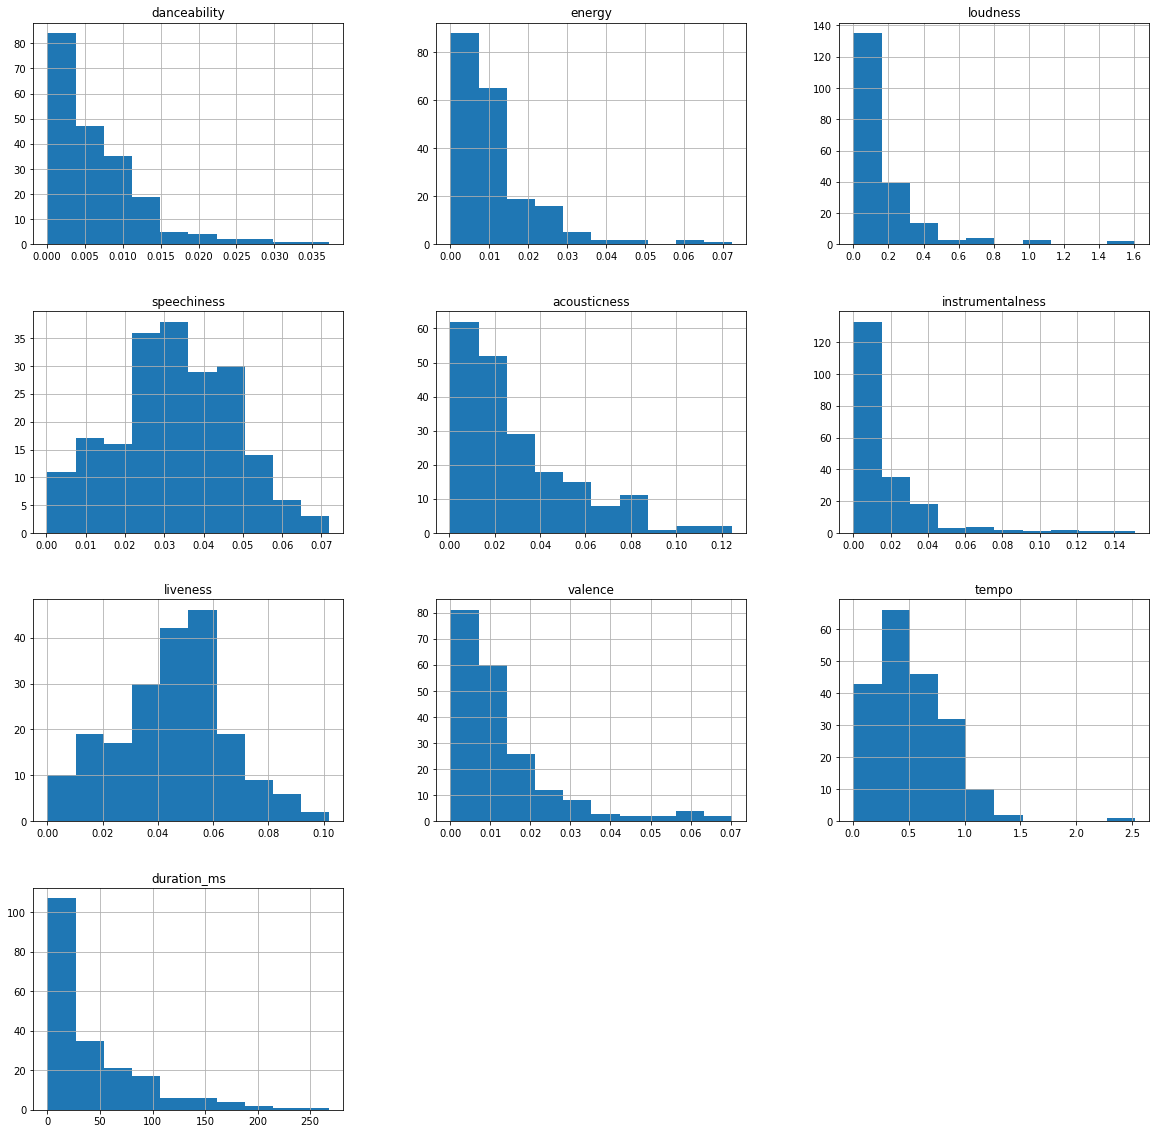

In [106]:
# Plots the differences for each feature
pd.DataFrame(differences)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))
plt.savefig('var_differences.jpg')

In [104]:
import matplotlib.pyplot as plt

In [105]:
plt.savefig('var_differences.jpg')

<Figure size 432x288 with 0 Axes>

### Edge Legitimacy